<a href="https://colab.research.google.com/github/nilakanta123/Short-Term-Load-Forecasting/blob/main/Parallel_2DCNN_LSTM_GAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import & functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
import math

from sklearn import metrics
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.utils import to_categorical
from numpy import argmax

from tensorflow.keras import Model, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers

!pip install pyts
from pyts.image import GramianAngularField

!pip install ipython-autotime
%load_ext autotime

# !pip install keras-tuner --upgrade
# import keras_tuner

import gc

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.2 MB/s eta 0:00:00
Mounted at /content/drive
time: 1min 50s (started: 2024-01-27 05:22:41 +00:00)


In [ ]:
LOOKBACK=168
LOOKAHEAD=24

def reframe(data, lookback, lookahead):
    x_load, y_load = [],[]
    start = 0
    for _ in range(len(data)):
        feature_end = start + lookback
        label_end = feature_end + lookahead
        if label_end <= len(data):
            # historical load feature
            v = data[start:feature_end,0]
            # v = v.reshape(len(v),1)
            x_load.append(v)
            # load labels
            v = data[feature_end:label_end,0]
            # v = v.reshape(len(v),1)
            y_load.append(v)
        start += lookahead
    x_load = np.asarray(x_load).astype('float32')
    y_load = np.asarray(y_load).astype('float32')
    return x_load, y_load

def evaluate(ori, pre):
    ori, pre = ori.flatten(),pre.flatten()
    mae = metrics.mean_absolute_error(ori, pre)
    mape = metrics.mean_absolute_percentage_error(ori, pre)*100
    r2 = metrics.r2_score(ori, pre)
    print('\nEvaluation metric results:-\n')
    # print(f'MAE is : {mae}')
    print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}')

def pplot(ori,pre,history):
    ori, pre = ori.flatten(),pre.flatten()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    axs[0].plot(ori[:100], label="Actual Load", color='blue', linewidth=1)
    axs[0].plot(pre[:100], label="Predicted Load", color='red', linewidth=1)
    axs[0].set_title("Prediction")
    axs[0].set_ylabel("Load MWt")
    axs[0].set_xlabel("Time")
    axs[1].plot(history.history['loss'], label="Training Loss", color='blue', linewidth=1)
    axs[1].plot(history.history['val_loss'], label="Validation Loss", color='red', linewidth=1)
    axs[1].set_title("Learning Curve")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    plt.show()

# # Method to check missing entries in the series data.
# dataset['Day'] = dataset.index.date
# check = dataset.groupby("Day").size().values
# s=0
# for i,v in enumerate(check):
#     s=s+v
#     if v!=24:
#         print(dataset.iloc[s-1]["Day"])

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return np.array([argmax(vector) for vector in encoded_seq])

time: 3.13 ms (started: 2024-01-27 05:24:40 +00:00)


# 1.AEP

In [ ]:
path = "/content/drive/MyDrive/DATASETS/AmericanElectricPowerHourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()



Xs : (4940, 168, 1), Ys : (4940, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (4940, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


3324

time: 18.2 s (started: 2024-01-27 05:26:34 +00:00)


In [ ]:
print(Yt.tolist())
print("\n")

[[11979.0, 11585.0, 11425.0, 11462.0, 11664.0, 12438.0, 13677.0, 14195.0, 14346.0, 14269.0, 14311.0, 14239.0, 14044.0, 14040.0, 13892.0, 13814.0, 13688.0, 13556.0, 13459.0, 13508.0, 13888.0, 13956.0, 13142.0, 12390.0], [11939.0, 11639.0, 11608.0, 11653.0, 11890.0, 12712.0, 13843.0, 14375.0, 14294.0, 14154.0, 13972.0, 13804.0, 13706.0, 13709.0, 13588.0, 13329.0, 13271.0, 13206.0, 13188.0, 13319.0, 13658.0, 13637.0, 12903.0, 12019.0], [11587.0, 11361.0, 11264.0, 11259.0, 11572.0, 12378.0, 13510.0, 13977.0, 14132.0, 14068.0, 14116.0, 13994.0, 13961.0, 13822.0, 13671.0, 13413.0, 13300.0, 13161.0, 12934.0, 12817.0, 13194.0, 13062.0, 12564.0, 11850.0], [11374.0, 11004.0, 10905.0, 10963.0, 11126.0, 11459.0, 11910.0, 12377.0, 12803.0, 13013.0, 13035.0, 12866.0, 12818.0, 12754.0, 12587.0, 12178.0, 12547.0, 12589.0, 12582.0, 12549.0, 12826.0, 13032.0, 12555.0, 12099.0], [11673.0, 11552.0, 11395.0, 11505.0, 11427.0, 11801.0, 12136.0, 12513.0, 12821.0, 12823.0, 12568.0, 12385.0, 12327.0, 12149.0, 

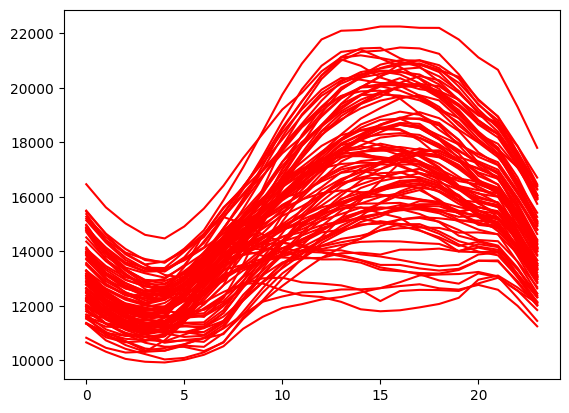

time: 430 ms (started: 2024-01-24 05:06:45 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:02:25
4/4 [==============================] - 1s 10ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 29ms/step

Single Day Inference Time 84.84983444213867 ms

Evaluation metric results:-

MAPE is : 3.3443745225667953
R2 is : 0.9252860408413458


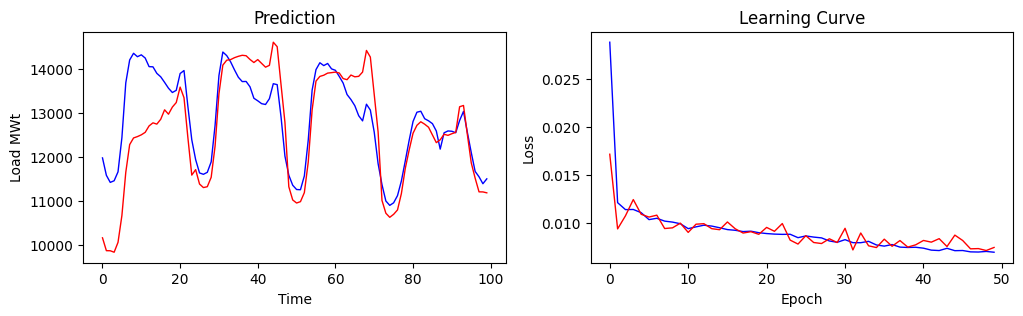



[[10170.6533203125], [9880.0576171875], [9878.263671875], [9845.03515625], [10068.8525390625], [10675.705078125], [11653.1328125], [12280.0322265625], [12430.5947265625], [12461.4853515625], [12501.1943359375], [12557.5078125], [12702.7138671875], [12772.4599609375], [12743.828125], [12853.07421875], [13067.4033203125], [12968.1806640625], [13129.2158203125], [13231.6376953125], [13581.291015625], [13340.818359375], [12435.798828125], [11589.9521484375], [11713.4970703125], [11387.6298828125], [11307.65625], [11327.515625], [11540.0947265625], [12243.2236328125], [13430.265625], [14078.1953125], [14190.044921875], [14203.4091796875], [14246.83984375], [14277.8173828125], [14300.998046875], [14291.0029296875], [14206.54296875], [14137.416015625], [14203.7998046875], [14116.810546875], [14032.2197265625], [14073.578125], [14596.6533203125], [14495.96484375], [13632.1669921875], [12782.7919921875], [11326.478515625], [11028.1474609375], [10958.525390625], [10989.1865234375], [11193.3681

In [ ]:
# CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:39
4/4 [==============================] - 0s 4ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 54ms/step

Single Day Inference Time 145.64251899719238 ms

Evaluation metric results:-

MAPE is : 4.192708805203438
R2 is : 0.9078752966238354


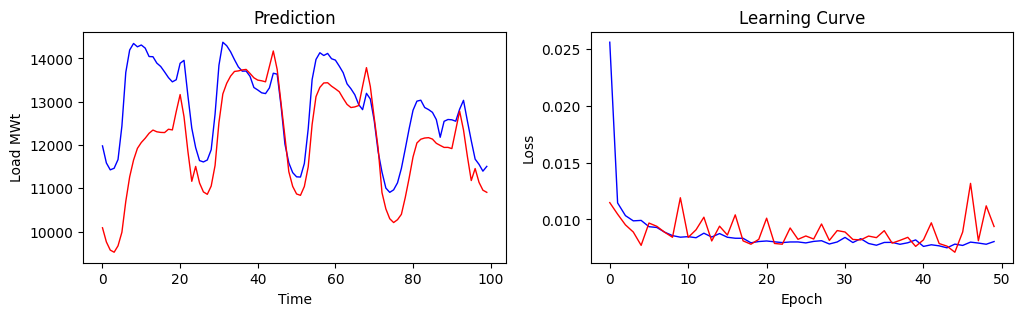



[[10086.29296875], [9758.990234375], [9570.6552734375], [9521.373046875], [9669.3857421875], [9983.47265625], [10695.580078125], [11263.5078125], [11650.779296875], [11922.2626953125], [12057.5263671875], [12155.5341796875], [12270.275390625], [12344.876953125], [12304.9296875], [12290.55859375], [12287.169921875], [12364.1435546875], [12347.8583984375], [12774.41015625], [13165.3232421875], [12652.857421875], [11854.12890625], [11160.228515625], [11504.5703125], [11121.5283203125], [10915.2763671875], [10859.75390625], [11050.0166015625], [11526.5068359375], [12519.9560546875], [13179.1640625], [13425.8505859375], [13592.05078125], [13699.556640625], [13711.9228515625], [13734.7177734375], [13746.3173828125], [13653.9677734375], [13553.193359375], [13499.38671875], [13483.65234375], [13460.029296875], [13814.4560546875], [14172.455078125], [13744.4970703125], [12966.17578125], [12190.3017578125], [11383.2490234375], [11042.169921875], [10868.0361328125], [10836.087890625], [11040.44

In [ ]:
# 1. ANN
inputs = Input(shape=(LOOKBACK,1))
x = Flatten()(inputs)
x = Dense(100, activation="relu")(x)
x = Dense(48, activation="relu")(x)
outputs = Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Inputs : (None, 168, 1)
LSTM+DROPOUT : (None, 50)
REPEAT VECTOR : (None, 24, 50)
LSTM2+DROPOUT : (None, 24, 50)
TIME DISTRIBUTED : (None, 24, 1)
OUTPUT : (None, 24)
Epoch 1/50
31/31 [==============================] - 8s 63ms/step - loss: 0.0499 - val_loss: 0.0226
Epoch 2/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0202 - val_loss: 0.0148
Epoch 3/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0181 - val_loss: 0.0149
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0169 - val_loss: 0.0131
Epoch 5/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0162 - val_loss: 0.0129
Epoch 6/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0158 - val_loss: 0.0111
Epoch 7/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 0.0120
Epoch 8/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0146 - val_loss: 0.0123
Epoch 9/50
31/31 [=========================

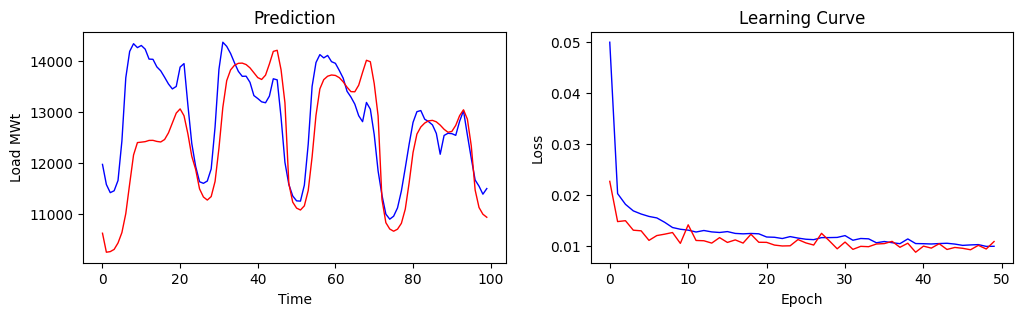



[[10629.3447265625], [10256.87109375], [10268.841796875], [10312.0576171875], [10438.51953125], [10642.345703125], [11013.556640625], [11596.32421875], [12163.568359375], [12406.8515625], [12415.6162109375], [12425.162109375], [12449.2431640625], [12450.6669921875], [12429.7470703125], [12418.9482421875], [12467.1513671875], [12598.1240234375], [12791.7490234375], [12985.2548828125], [13067.4453125], [12933.8291015625], [12578.208984375], [12138.998046875], [11880.7109375], [11499.6103515625], [11340.3564453125], [11279.5361328125], [11348.10546875], [11645.20703125], [12295.8603515625], [13096.5595703125], [13621.5947265625], [13832.2900390625], [13923.4873046875], [13961.431640625], [13965.4560546875], [13936.955078125], [13872.095703125], [13776.6669921875], [13681.1640625], [13644.853515625], [13729.244140625], [13949.1181640625], [14194.8330078125], [14217.033203125], [13835.279296875], [13187.056640625], [11605.5380859375], [11239.4560546875], [11121.8486328125], [11084.7958984

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
print("Inputs :",inputs.shape)
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
print("LSTM+DROPOUT :",x.shape)
x = RepeatVector(24)(x)
print("REPEAT VECTOR :",x.shape)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
print("LSTM2+DROPOUT :",x.shape)
x = TimeDistributed(Dense(1, activation="linear"))(x)
print("TIME DISTRIBUTED :",x.shape)
x= Flatten()(x)
print("OUTPUT :",x.shape)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:02:26
4/4 [==============================] - 2s 11ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 68ms/step

Single Day Inference Time 167.60635375976562 ms

Evaluation metric results:-

MAPE is : 3.9981160312891006
R2 is : 0.8996790172314704


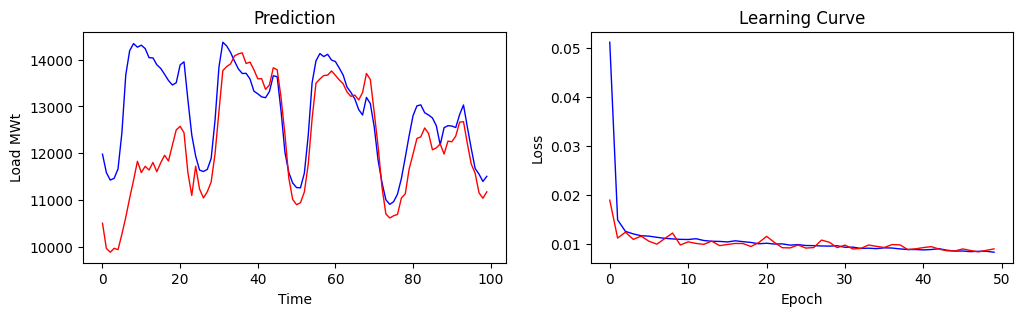



[[10502.0654296875], [9960.6044921875], [9880.8388671875], [9965.2841796875], [9935.5419921875], [10266.966796875], [10630.5888671875], [11040.033203125], [11420.2861328125], [11826.40234375], [11585.6552734375], [11719.6689453125], [11640.2138671875], [11802.5224609375], [11604.4169921875], [11795.7158203125], [11955.0888671875], [11833.1201171875], [12171.6220703125], [12499.09375], [12574.783203125], [12438.4921875], [11584.9619140625], [11094.7548828125], [11721.4970703125], [11232.9375], [11043.1767578125], [11176.0263671875], [11385.4873046875], [11990.9150390625], [12893.42578125], [13768.2607421875], [13855.103515625], [13911.2138671875], [14080.2294921875], [14125.6796875], [14147.3916015625], [13919.90234375], [13949.828125], [13787.029296875], [13592.251953125], [13594.3818359375], [13366.4072265625], [13460.38671875], [13828.18359375], [13785.4638671875], [13188.828125], [12400.48046875], [11468.3818359375], [11010.248046875], [10897.81640625], [10939.4560546875], [11169.

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(100, return_sequences=True)(inputs)
x = layers.GRU(50, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.001),loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Epoch 1/50
124/124 [==============================] - 9s 22ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 2/50
124/124 [==============================] - 1s 10ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 3/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 4/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 5/50
124/124 [==============================] - 2s 16ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 6/50
124/124 [==============================] - 2s 13ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7/50
124/124 [==============================] - 1s 9ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 8/50
124/124 [==============================] - 1s 9ms/step - loss

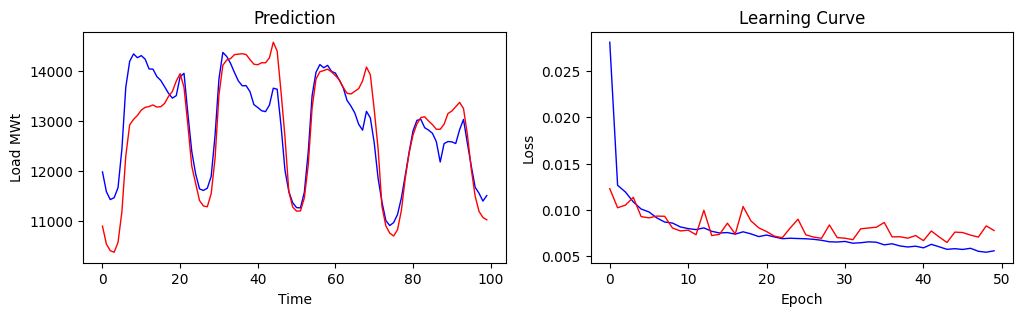



[[10892.2578125], [10534.4306640625], [10400.9833984375], [10369.8271484375], [10567.01953125], [11182.51953125], [12298.8095703125], [12923.1484375], [13033.7275390625], [13111.5009765625], [13219.720703125], [13273.927734375], [13290.24609375], [13322.01171875], [13279.8916015625], [13287.125], [13352.5751953125], [13493.509765625], [13591.1171875], [13799.5537109375], [13947.8525390625], [13675.4443359375], [12916.037109375], [12094.0244140625], [11747.44140625], [11405.486328125], [11297.2060546875], [11280.8076171875], [11544.177734375], [12253.828125], [13523.0478515625], [14117.6767578125], [14222.5849609375], [14252.3037109375], [14330.91015625], [14340.576171875], [14349.05859375], [14332.7744140625], [14231.845703125], [14138.986328125], [14128.193359375], [14168.310546875], [14167.98046875], [14265.419921875], [14579.560546875], [14400.7822265625], [13580.08203125], [12688.05078125], [11587.7431640625], [11274.703125], [11193.4580078125], [11197.404296875], [11458.14550781

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=1)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:44
1/1 [==============================] - 1s 604ms/step

Single Day Inference Time 674.6551990509033 ms
4/4 [==============================] - 0s 8ms/step

Evaluation metric results:-

MAPE is : 3.5306021571159363
R2 is : 0.9202650044769004


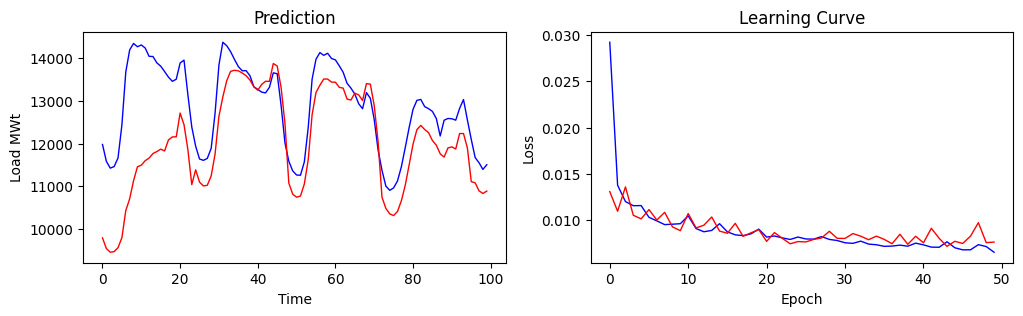



[[9791.302734375], [9540.6171875], [9455.328125], [9469.6181640625], [9561.603515625], [9797.21484375], [10431.1806640625], [10706.970703125], [11130.5234375], [11456.888671875], [11494.5869140625], [11599.787109375], [11660.3720703125], [11767.169921875], [11813.0400390625], [11870.1171875], [11828.2724609375], [12087.0791015625], [12156.7958984375], [12158.8115234375], [12715.7333984375], [12443.8974609375], [11856.9365234375], [11038.40625], [11385.8623046875], [11096.9208984375], [11007.1845703125], [11024.216796875], [11242.6513671875], [11755.025390625], [12641.3818359375], [13092.8935546875], [13470.9404296875], [13692.3974609375], [13717.302734375], [13705.552734375], [13654.0546875], [13590.6611328125], [13487.44140625], [13331.349609375], [13250.748046875], [13385.6494140625], [13460.619140625], [13457.138671875], [13876.00390625], [13818.2158203125], [13321.8564453125], [12476.865234375], [11074.806640625], [10815.4853515625], [10744.4404296875], [10771.5537109375], [11054

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Epoch 1/50
31/31 [==============================] - 16s 202ms/step - loss: 0.0676 - val_loss: 0.0340
Epoch 2/50
31/31 [==============================] - 4s 123ms/step - loss: 0.0273 - val_loss: 0.0153
Epoch 3/50
31/31 [==============================] - 5s 155ms/step - loss: 0.0170 - val_loss: 0.0121
Epoch 4/50
31/31 [==============================] - 4s 115ms/step - loss: 0.0154 - val_loss: 0.0103
Epoch 5/50
31/31 [==============================] - 4s 123ms/step - loss: 0.0141 - val_loss: 0.0104
Epoch 6/50
31/31 [==============================] - 6s 211ms/step - loss: 0.0141 - val_loss: 0.0120
Epoch 7/50
31/31 [==============================] - 4s 139ms/step - loss: 0.0138 - val_loss: 0.0103
Epoch 8/50
31/31 [==============================] - 5s 167ms/step - loss: 0.0129 - val_loss: 0.0106
Epoch 9/50
31/31 [==============================] - 4s 141ms/step - loss: 0.0127 - val_loss: 0.0111
Epoch 10/50
31/31 [==============================] - 4s 120ms/step - loss: 0.0127 - val_loss: 0.010

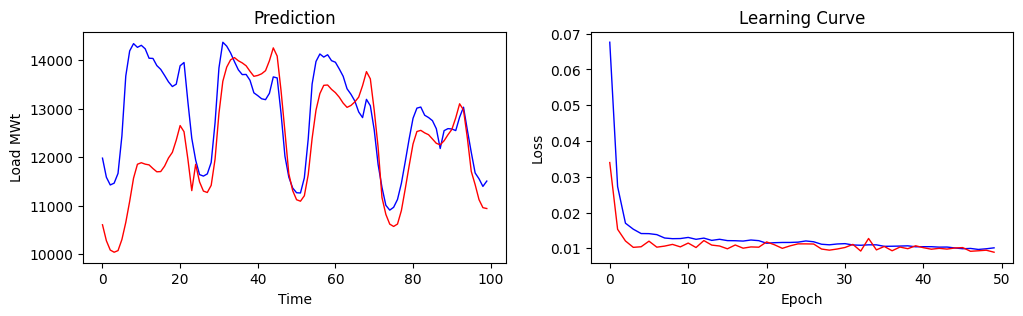



[[10601.88671875], [10272.3662109375], [10079.71875], [10034.689453125], [10068.1298828125], [10297.2529296875], [10650.763671875], [11085.966796875], [11565.1474609375], [11852.732421875], [11884.6123046875], [11855.1103515625], [11839.6015625], [11764.083984375], [11696.986328125], [11701.560546875], [11814.7578125], [11982.10546875], [12098.9521484375], [12351.5732421875], [12652.626953125], [12525.4482421875], [11958.2880859375], [11307.8046875], [11851.6591796875], [11488.6298828125], [11298.53125], [11269.205078125], [11417.025390625], [11958.1865234375], [12903.8427734375], [13567.673828125], [13860.4599609375], [14011.6962890625], [14056.9189453125], [13991.7470703125], [13947.58984375], [13888.109375], [13774.35546875], [13670.607421875], [13688.4873046875], [13722.955078125], [13787.025390625], [13991.7802734375], [14258.04296875], [14088.7890625], [13371.6552734375], [12526.7451171875], [11655.294921875], [11306.986328125], [11119.6337890625], [11089.0517578125], [11201.80

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=1)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 2.COMED

In [ ]:
path = "/content/drive/MyDrive/DATASETS/COMED_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()


Xs : (2657, 168, 1), Ys : (2657, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (2657, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


38123

time: 5.81 s (started: 2024-01-27 05:53:37 +00:00)


In [ ]:
print(Yt.tolist())
print("\n")

[[8876.0, 8474.0, 8251.0, 8156.0, 8156.0, 8432.0, 9091.0, 9872.0, 10456.0, 10629.0, 10708.0, 10764.0, 10713.0, 10643.0, 10666.0, 10556.0, 10437.0, 10286.0, 10184.0, 10037.0, 10223.0, 10592.0, 10251.0, 9662.0], [9056.0, 8720.0, 8516.0, 8389.0, 8435.0, 8692.0, 9363.0, 10095.0, 10596.0, 10727.0, 10693.0, 10767.0, 10719.0, 10722.0, 10739.0, 10659.0, 10542.0, 10409.0, 10263.0, 10077.0, 10159.0, 10454.0, 10082.0, 9430.0], [8832.0, 8399.0, 8146.0, 8021.0, 8015.0, 8270.0, 8900.0, 9617.0, 10161.0, 10395.0, 10491.0, 10590.0, 10582.0, 10581.0, 10605.0, 10463.0, 10312.0, 10209.0, 10160.0, 10232.0, 10362.0, 10518.0, 10251.0, 9685.0], [9127.0, 8698.0, 8478.0, 8289.0, 8281.0, 8376.0, 8624.0, 8806.0, 9061.0, 9317.0, 9466.0, 9544.0, 9455.0, 9331.0, 9164.0, 9039.0, 8901.0, 8896.0, 8858.0, 8908.0, 9110.0, 9618.0, 9491.0, 9139.0], [8752.0, 8403.0, 8243.0, 8098.0, 8087.0, 8113.0, 8254.0, 8231.0, 8415.0, 8560.0, 8705.0, 8747.0, 8733.0, 8713.0, 8645.0, 8605.0, 8547.0, 8581.0, 8664.0, 8696.0, 8928.0, 9391.0, 

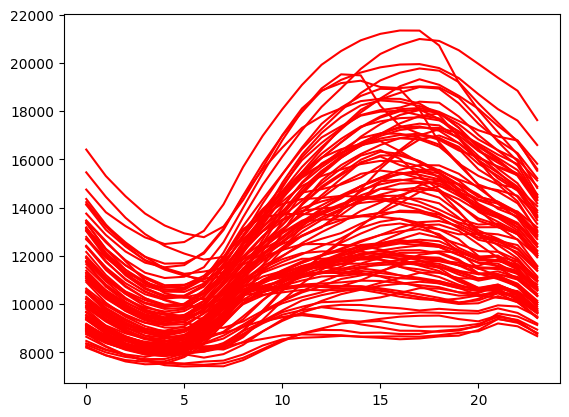

time: 883 ms (started: 2023-11-28 08:04:52 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:01:11
4/4 [==============================] - 1s 11ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 29ms/step

Single Day Inference Time 112.51974105834961 ms

Evaluation metric results:-

MAPE is : 5.665480345487595
R2 is : 0.8648266904505455


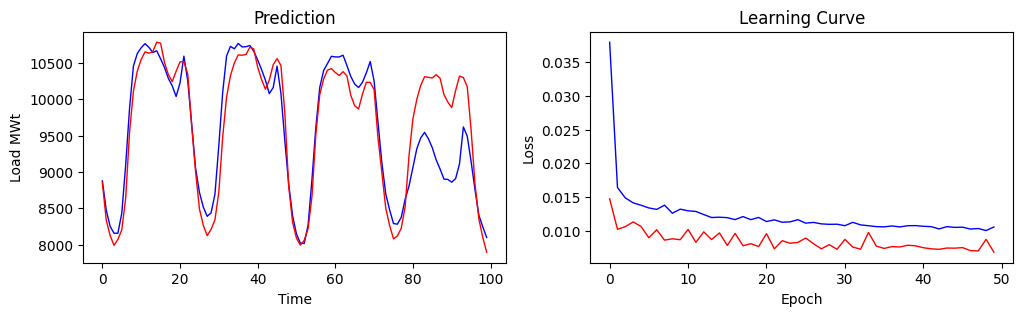



[[8850.9208984375], [8336.76171875], [8124.03125], [7988.90771484375], [8069.8701171875], [8202.0263671875], [8635.17578125], [9543.33984375], [10111.3505859375], [10386.04296875], [10548.822265625], [10651.5751953125], [10632.9326171875], [10654.6318359375], [10783.822265625], [10770.75390625], [10505.345703125], [10338.251953125], [10242.1943359375], [10384.294921875], [10512.7529296875], [10518.3720703125], [10343.6123046875], [9638.62890625], [9011.083984375], [8492.375], [8265.7451171875], [8122.84765625], [8208.6162109375], [8341.0185546875], [8721.357421875], [9480.9931640625], [10030.7861328125], [10324.205078125], [10498.8154296875], [10609.1796875], [10605.3017578125], [10615.037109375], [10713.62890625], [10692.154296875], [10442.978515625], [10272.009765625], [10138.2119140625], [10263.1884765625], [10472.96875], [10558.78125], [10463.3486328125], [9813.513671875], [8803.00390625], [8308.546875], [8088.0830078125], [7993.25244140625], [8058.79296875], [8219.31640625], [86

In [ ]:
# CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:21
4/4 [==============================] - 0s 3ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 17ms/step

Single Day Inference Time 51.01180076599121 ms

Evaluation metric results:-

MAPE is : 7.373838126659393
R2 is : 0.8147483420964945


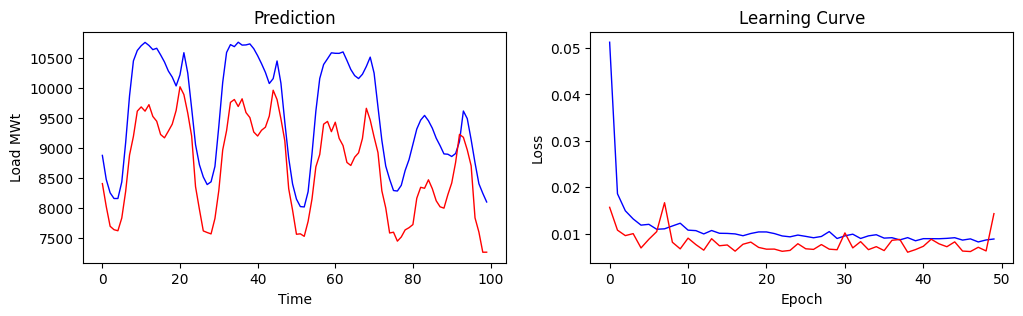



[[8404.7607421875], [8022.2060546875], [7692.07666015625], [7635.0439453125], [7617.1728515625], [7829.9296875], [8275.6875], [8882.5703125], [9194.07421875], [9615.509765625], [9686.2431640625], [9615.443359375], [9723.744140625], [9527.4189453125], [9446.5654296875], [9225.2978515625], [9169.6005859375], [9281.466796875], [9398.193359375], [9626.39453125], [10022.908203125], [9892.521484375], [9581.76953125], [9199.46484375], [8354.0234375], [7975.22119140625], [7614.5322265625], [7587.88671875], [7564.5654296875], [7822.42626953125], [8290.431640625], [8967.158203125], [9290.0576171875], [9762.439453125], [9810.177734375], [9692.638671875], [9821.53515625], [9591.6416015625], [9508.3720703125], [9266.8759765625], [9200.017578125], [9295.775390625], [9347.337890625], [9533.6845703125], [9965.197265625], [9808.802734375], [9486.9580078125], [9120.2314453125], [8320.470703125], [7960.70947265625], [7558.62744140625], [7566.10107421875], [7524.2041015625], [7773.45849609375], [8146.66

In [ ]:
# 1. ANN
inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(48, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss=mse, metrics=[mse])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:23
4/4 [==============================] - 1s 7ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 25ms/step

Single Day Inference Time 71.15387916564941 ms

Evaluation metric results:-

MAPE is : 5.984199419617653
R2 is : 0.8547386328749527


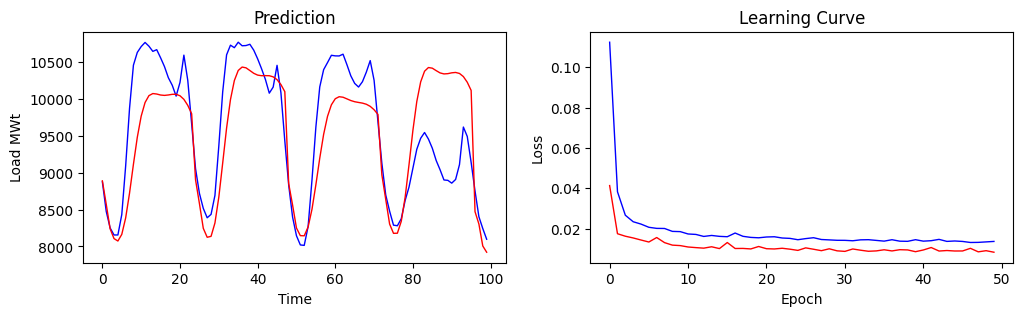



[[8888.96484375], [8570.4765625], [8238.9248046875], [8106.9375], [8074.1162109375], [8163.89599609375], [8386.8876953125], [8723.1181640625], [9112.884765625], [9479.7001953125], [9765.787109375], [9950.4287109375], [10043.6640625], [10071.6123046875], [10065.2724609375], [10051.7275390625], [10046.7353515625], [10052.486328125], [10061.3173828125], [10061.486328125], [10041.6162109375], [9993.203125], [9911.896484375], [9798.1494140625], [8904.21484375], [8582.796875], [8246.0625], [8124.947265625], [8137.46728515625], [8318.50390625], [8668.71484375], [9131.6943359375], [9603.9228515625], [9990.1630859375], [10247.7353515625], [10384.3857421875], [10430.6513671875], [10420.1337890625], [10383.556640625], [10345.8203125], [10321.6083984375], [10313.431640625], [10314.388671875], [10313.1337890625], [10298.078125], [10259.9599609375], [10193.2900390625], [10097.2294921875], [8850.2841796875], [8562.08984375], [8250.5634765625], [8146.73681640625], [8144.8408203125], [8263.9736328125

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
x = RepeatVector(24)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(1, activation="linear"))(x)
x= Flatten()(x)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:01:16
4/4 [==============================] - 2s 9ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 50ms/step

Single Day Inference Time 149.87850189208984 ms

Evaluation metric results:-

MAPE is : 6.452436000108719
R2 is : 0.8491556671779592


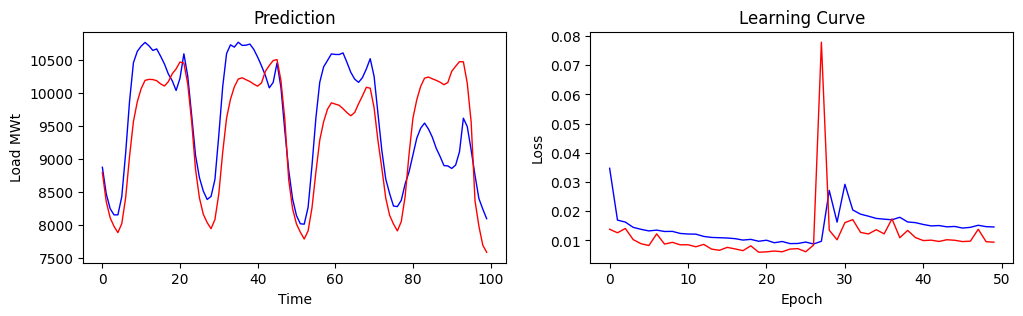



[[8796.9755859375], [8355.5478515625], [8113.11669921875], [7981.82177734375], [7887.509765625], [8023.19287109375], [8415.0703125], [9038.2392578125], [9566.69921875], [9866.8134765625], [10065.951171875], [10190.146484375], [10204.916015625], [10202.5146484375], [10184.134765625], [10136.6142578125], [10104.9404296875], [10170.943359375], [10289.6435546875], [10363.86328125], [10467.8642578125], [10451.669921875], [10133.318359375], [9568.9384765625], [8844.880859375], [8413.583984375], [8165.7470703125], [8038.69677734375], [7947.0078125], [8085.37451171875], [8476.2705078125], [9102.875], [9621.2236328125], [9903.30078125], [10092.4267578125], [10209.1572265625], [10229.1416015625], [10200.052734375], [10172.85546875], [10133.8046875], [10102.7080078125], [10152.7373046875], [10327.384765625], [10415.041015625], [10489.7568359375], [10504.2275390625], [10187.91015625], [9600.6513671875], [8687.9287109375], [8250.021484375], [8018.32373046875], [7893.869140625], [7790.56396484375]

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(100, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2, batch_size=32, verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:45
4/4 [==============================] - 1s 6ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 59ms/step

Single Day Inference Time 171.11611366271973 ms

Evaluation metric results:-

MAPE is : 6.057589128613472
R2 is : 0.838768293858546


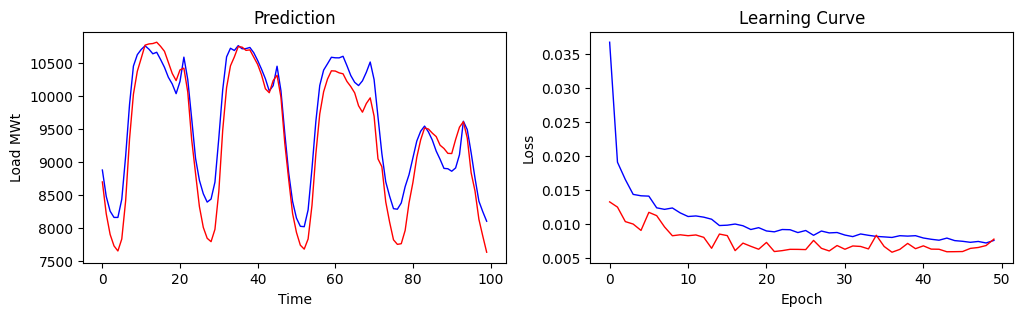



[[8695.119140625], [8210.5537109375], [7897.36669921875], [7723.076171875], [7645.90771484375], [7828.14990234375], [8411.02734375], [9348.95703125], [10028.24609375], [10376.484375], [10573.5556640625], [10774.6806640625], [10792.8564453125], [10798.77734375], [10818.7353515625], [10755.8798828125], [10680.30078125], [10512.353515625], [10344.4296875], [10235.693359375], [10398.12109375], [10425.0537109375], [10061.2265625], [9341.7080078125], [8826.451171875], [8320.333984375], [8004.701171875], [7839.2685546875], [7787.5625], [7974.8759765625], [8549.345703125], [9480.0283203125], [10128.3369140625], [10460.111328125], [10594.76171875], [10752.7353515625], [10743.7998046875], [10694.84765625], [10702.2421875], [10591.3994140625], [10481.888671875], [10323.5341796875], [10111.08984375], [10050.771484375], [10235.59375], [10316.98828125], [9983.8828125], [9280.1044921875], [8732.515625], [8216.419921875], [7928.08203125], [7733.98779296875], [7674.36865234375], [7828.23291015625], [

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:21
1/1 [==============================] - 1s 558ms/step

Single Day Inference Time 621.8020915985107 ms
4/4 [==============================] - 0s 7ms/step

Evaluation metric results:-

MAPE is : 6.383688747882843
R2 is : 0.8076069741484379


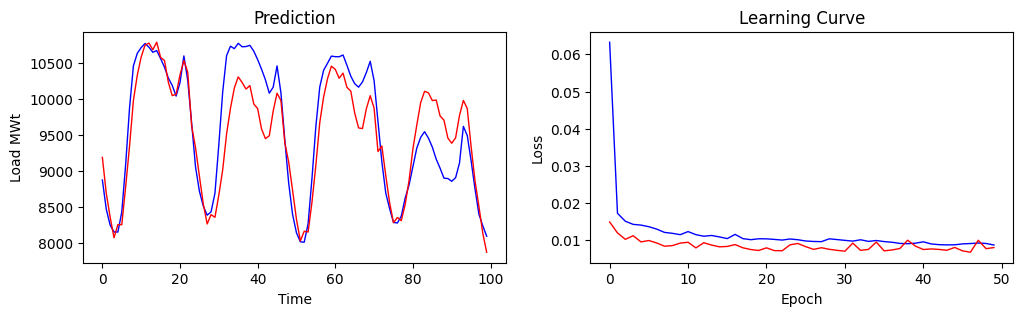



[[9188.6318359375], [8693.935546875], [8362.619140625], [8076.70166015625], [8258.576171875], [8257.1376953125], [8782.076171875], [9344.5390625], [9977.8369140625], [10327.4169921875], [10577.1962890625], [10742.9169921875], [10769.740234375], [10677.796875], [10781.9365234375], [10571.3046875], [10528.736328125], [10226.5283203125], [10042.916015625], [10060.9375], [10330.18359375], [10528.470703125], [10367.01953125], [9623.6728515625], [9322.763671875], [8928.7099609375], [8542.16796875], [8267.8232421875], [8395.99609375], [8359.2109375], [8666.5126953125], [9018.193359375], [9512.8359375], [9868.5517578125], [10148.9453125], [10302.1640625], [10225.1005859375], [10134.1728515625], [10182.5048828125], [9928.1708984375], [9863.4091796875], [9582.69140625], [9447.9228515625], [9487.544921875], [9828.6708984375], [10076.404296875], [9975.591796875], [9391.9150390625], [9124.7138671875], [8732.8466796875], [8332.6201171875], [8032.86328125], [8166.89111328125], [8155.537109375], [85

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Epoch 1/50
17/17 [==============================] - 7s 162ms/step - loss: 0.1162 - val_loss: 0.0408
Epoch 2/50
17/17 [==============================] - 2s 93ms/step - loss: 0.0587 - val_loss: 0.0277
Epoch 3/50
17/17 [==============================] - 2s 92ms/step - loss: 0.0526 - val_loss: 0.0259
Epoch 4/50
17/17 [==============================] - 2s 93ms/step - loss: 0.0313 - val_loss: 0.0144
Epoch 5/50
17/17 [==============================] - 2s 93ms/step - loss: 0.0247 - val_loss: 0.0141
Epoch 6/50
17/17 [==============================] - 2s 103ms/step - loss: 0.0224 - val_loss: 0.0126
Epoch 7/50
17/17 [==============================] - 2s 115ms/step - loss: 0.0209 - val_loss: 0.0125
Epoch 8/50
17/17 [==============================] - 2s 93ms/step - loss: 0.0206 - val_loss: 0.0127
Epoch 9/50
17/17 [==============================] - 2s 94ms/step - loss: 0.0210 - val_loss: 0.0134
Epoch 10/50
17/17 [==============================] - 2s 94ms/step - loss: 0.0192 - val_loss: 0.0119
Epoch 

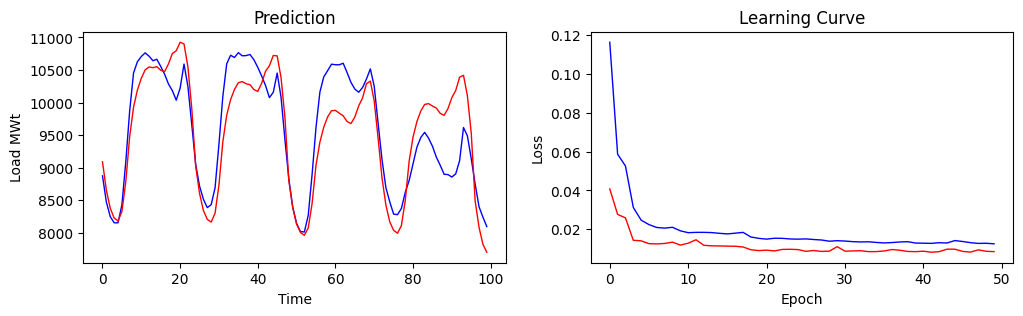



[[9092.1474609375], [8653.4853515625], [8378.8115234375], [8230.1845703125], [8185.12841796875], [8328.40625], [8784.7421875], [9477.4736328125], [9930.244140625], [10195.2841796875], [10374.2431640625], [10504.0615234375], [10546.99609375], [10536.5087890625], [10551.94140625], [10498.0439453125], [10474.712890625], [10595.6025390625], [10753.220703125], [10797.314453125], [10927.2724609375], [10901.384765625], [10551.064453125], [9910.3701171875], [9030.681640625], [8607.0625], [8343.3447265625], [8208.5283203125], [8166.76220703125], [8303.2490234375], [8736.998046875], [9398.8134765625], [9807.8681640625], [10045.564453125], [10202.94140625], [10305.853515625], [10322.828125], [10289.509765625], [10275.009765625], [10200.6982421875], [10172.83203125], [10297.4482421875], [10481.6552734375], [10565.9482421875], [10724.0771484375], [10717.7333984375], [10382.3984375], [9771.880859375], [8804.123046875], [8392.7060546875], [8135.029296875], [8007.9599609375], [7963.806640625], [8075

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=1)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 3.DEOK

In [ ]:
path = "/content/drive/MyDrive/DATASETS/DEOK_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()



Xs : (2292, 168, 1), Ys : (2292, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (2292, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


48941

time: 6.78 s (started: 2024-01-27 06:02:40 +00:00)


In [ ]:
print(Yt.tolist())
print("\n")

[[2375.0, 2281.0, 2247.0, 2216.0, 2276.0, 2457.0, 2735.0, 2863.0, 2896.0, 2923.0, 2971.0, 2934.0, 2916.0, 2866.0, 2847.0, 2824.0, 2787.0, 2791.0, 2737.0, 2724.0, 2798.0, 2816.0, 2628.0, 2454.0], [2327.0, 2271.0, 2223.0, 2251.0, 2287.0, 2460.0, 2765.0, 2888.0, 2898.0, 2845.0, 2876.0, 2885.0, 2885.0, 2860.0, 2876.0, 2849.0, 2817.0, 2806.0, 2751.0, 2745.0, 2833.0, 2835.0, 2644.0, 2463.0], [2331.0, 2246.0, 2187.0, 2206.0, 2262.0, 2444.0, 2738.0, 2842.0, 2872.0, 2888.0, 2898.0, 2882.0, 2878.0, 2889.0, 2868.0, 2836.0, 2800.0, 2757.0, 2687.0, 2639.0, 2676.0, 2694.0, 2564.0, 2401.0], [2295.0, 2237.0, 2170.0, 2150.0, 2179.0, 2202.0, 2308.0, 2406.0, 2538.0, 2639.0, 2720.0, 2732.0, 2680.0, 2617.0, 2561.0, 2532.0, 2499.0, 2512.0, 2503.0, 2504.0, 2593.0, 2645.0, 2566.0, 2473.0], [2348.0, 2276.0, 2265.0, 2267.0, 2303.0, 2358.0, 2450.0, 2492.0, 2554.0, 2597.0, 2579.0, 2549.0, 2504.0, 2447.0, 2431.0, 2405.0, 2407.0, 2451.0, 2466.0, 2487.0, 2588.0, 2638.0, 2507.0, 2359.0], [2260.0, 2209.0, 2210.0, 2241

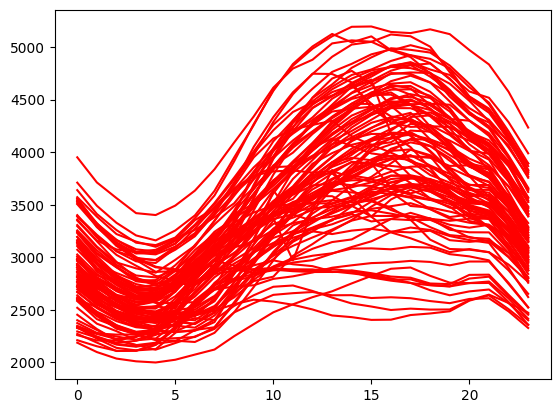

time: 306 ms (started: 2023-12-17 10:03:40 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:01:28
4/4 [==============================] - 1s 10ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 31ms/step

Single Day Inference Time 84.94281768798828 ms

Evaluation metric results:-

MAPE is : 4.921398684382439
R2 is : 0.8595773781173616


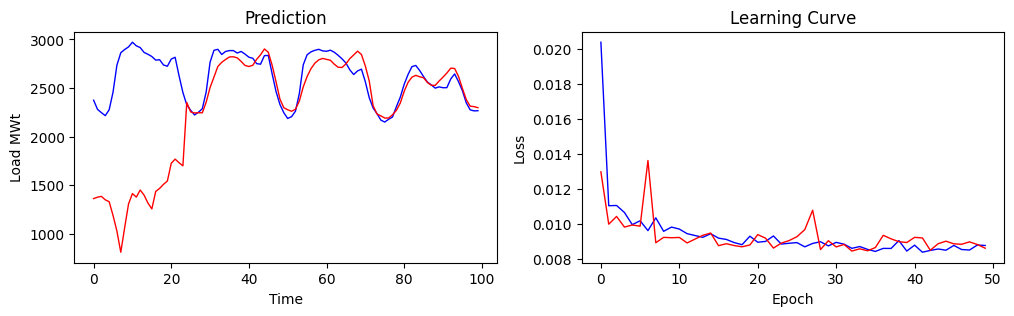



[[1363.5245361328125], [1377.5250244140625], [1386.3785400390625], [1350.7794189453125], [1331.4788818359375], [1190.4754638671875], [1029.30078125], [812.0394897460938], [1065.5499267578125], [1308.805908203125], [1414.6915283203125], [1378.51025390625], [1451.5584716796875], [1398.996826171875], [1316.9136962890625], [1257.3948974609375], [1436.844970703125], [1468.262451171875], [1509.7861328125], [1543.8798828125], [1726.4307861328125], [1769.3466796875], [1732.1552734375], [1700.52880859375], [2351.681640625], [2254.22265625], [2244.031494140625], [2246.032958984375], [2245.3095703125], [2354.564697265625], [2505.50537109375], [2612.25390625], [2721.739990234375], [2764.304443359375], [2793.960205078125], [2819.670166015625], [2821.32080078125], [2810.164306640625], [2773.818115234375], [2732.29931640625], [2721.196533203125], [2733.9638671875], [2795.147216796875], [2841.67138671875], [2901.703125], [2867.532958984375], [2733.158447265625], [2562.9296875], [2385.451416015625], 

In [ ]:
# CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:21
4/4 [==============================] - 0s 3ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 17ms/step

Single Day Inference Time 54.47864532470703 ms

Evaluation metric results:-

MAPE is : 6.01634606719017
R2 is : 0.832664829120618


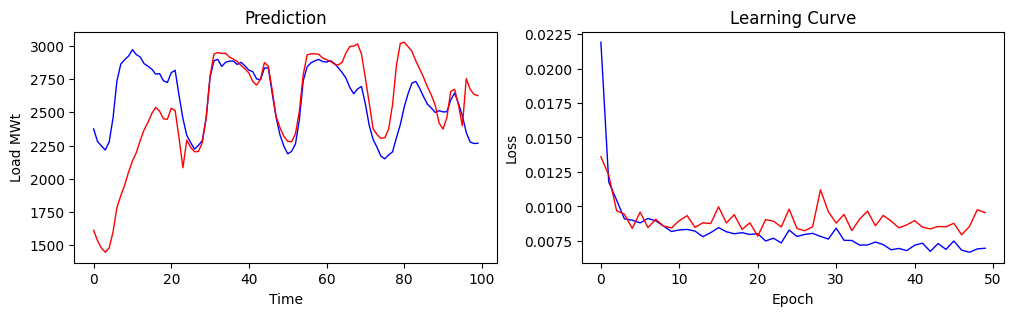



[[1611.8228759765625], [1534.0660400390625], [1478.563720703125], [1446.7928466796875], [1478.823974609375], [1598.903076171875], [1782.37548828125], [1872.3133544921875], [1951.2542724609375], [2049.940673828125], [2133.638427734375], [2196.29150390625], [2287.28125], [2367.161376953125], [2423.84912109375], [2491.906005859375], [2536.675048828125], [2507.884521484375], [2450.450927734375], [2447.30810546875], [2530.260009765625], [2512.74853515625], [2308.3125], [2082.73388671875], [2290.433349609375], [2236.20166015625], [2202.653076171875], [2205.06689453125], [2270.51318359375], [2458.597412109375], [2772.55078125], [2938.00390625], [2949.61669921875], [2942.51611328125], [2944.126953125], [2915.1982421875], [2900.657470703125], [2882.139404296875], [2851.84375], [2826.791748046875], [2795.299072265625], [2732.142578125], [2704.863525390625], [2750.39697265625], [2874.6826171875], [2847.099365234375], [2668.5166015625], [2469.275390625], [2384.553955078125], [2319.780517578125],

In [ ]:
# 1. ANN
inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(48, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss=mse, metrics=[mse])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:23
4/4 [==============================] - 1s 6ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 19ms/step

Single Day Inference Time 60.471296310424805 ms

Evaluation metric results:-

MAPE is : 5.881918594241142
R2 is : 0.8364164965161711


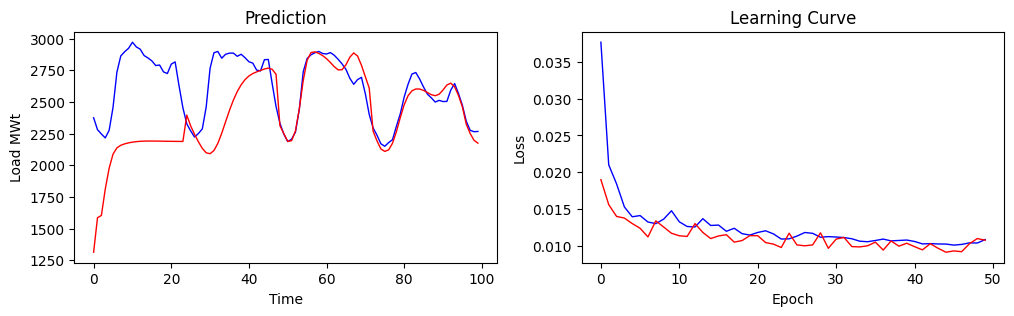



[[1314.0679931640625], [1586.430419921875], [1604.0767822265625], [1812.1893310546875], [1976.8543701171875], [2088.223388671875], [2137.29638671875], [2157.986083984375], [2169.15576171875], [2176.8515625], [2182.539306640625], [2186.569091796875], [2189.168212890625], [2190.621337890625], [2191.235107421875], [2191.28857421875], [2191.0048828125], [2190.54833984375], [2190.030029296875], [2189.519287109375], [2189.056640625], [2188.659912109375], [2188.334716796875], [2188.07763671875], [2396.177978515625], [2311.06689453125], [2244.190673828125], [2185.53759765625], [2133.231201171875], [2098.6337890625], [2091.345703125], [2116.52587890625], [2172.9365234375], [2252.70703125], [2343.63818359375], [2433.544189453125], [2514.042236328125], [2581.439697265625], [2635.12451171875], [2675.7373046875], [2704.535400390625], [2723.749267578125], [2736.977294921875], [2748.385498046875], [2759.806640625], [2766.7353515625], [2757.237060546875], [2717.1640625], [2312.19482421875], [2249.73

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
x = RepeatVector(24)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(1, activation="linear"))(x)
x= Flatten()(x)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:44
4/4 [==============================] - 1s 8ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 31ms/step

Single Day Inference Time 81.78424835205078 ms

Evaluation metric results:-

MAPE is : 5.061209574341774
R2 is : 0.8625889281713033


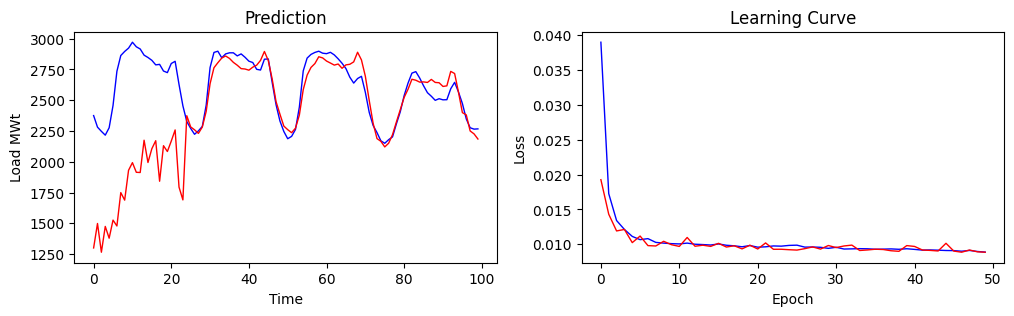



[[1299.6075439453125], [1498.2864990234375], [1264.8961181640625], [1474.546142578125], [1378.791259765625], [1525.8206787109375], [1478.0478515625], [1749.3013916015625], [1688.009765625], [1930.5599365234375], [1992.6024169921875], [1914.2210693359375], [1912.610107421875], [2174.81494140625], [1993.8304443359375], [2105.75146484375], [2170.8583984375], [1841.579345703125], [2130.317138671875], [2083.0224609375], [2167.581298828125], [2258.413818359375], [1793.952880859375], [1689.9361572265625], [2373.848876953125], [2282.93310546875], [2259.341552734375], [2230.415283203125], [2282.08056640625], [2409.230224609375], [2633.74560546875], [2763.544921875], [2804.25], [2842.00830078125], [2859.21337890625], [2839.375732421875], [2807.416748046875], [2784.1845703125], [2756.489990234375], [2753.431640625], [2743.92822265625], [2768.242431640625], [2784.36865234375], [2823.48046875], [2895.712158203125], [2821.793701171875], [2672.3154296875], [2488.067138671875], [2386.396728515625], 

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(100, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.001),loss=mse, metrics=[mse])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:32
4/4 [==============================] - 1s 5ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 28ms/step

Single Day Inference Time 93.21236610412598 ms

Evaluation metric results:-

MAPE is : 5.078062787652016
R2 is : 0.8645298078350476


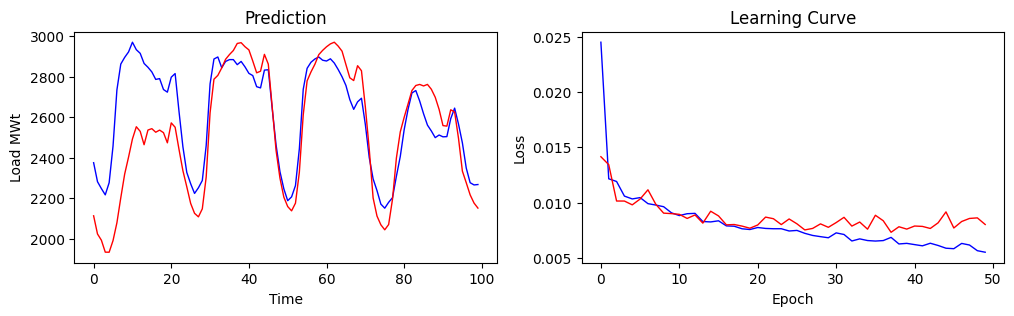



[[2112.30224609375], [2022.4017333984375], [1991.595458984375], [1932.458984375], [1932.1204833984375], [1989.6851806640625], [2077.774658203125], [2201.679931640625], [2318.704833984375], [2402.72900390625], [2492.2666015625], [2552.93115234375], [2530.027099609375], [2463.898681640625], [2536.579833984375], [2543.40869140625], [2525.7216796875], [2536.257568359375], [2523.547119140625], [2473.35595703125], [2572.017822265625], [2550.336181640625], [2440.60205078125], [2335.6142578125], [2255.932861328125], [2173.54736328125], [2124.576171875], [2107.2197265625], [2146.81396484375], [2304.28173828125], [2621.640869140625], [2787.977294921875], [2806.903076171875], [2843.7529296875], [2886.667236328125], [2910.087646484375], [2930.136962890625], [2964.927490234375], [2968.78076171875], [2948.68505859375], [2933.08642578125], [2877.989990234375], [2819.674560546875], [2827.56103515625], [2911.021728515625], [2862.65625], [2651.819091796875], [2435.81103515625], [2299.022705078125], [2

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:12
1/1 [==============================] - 0s 373ms/step

Single Day Inference Time 454.1125297546387 ms
4/4 [==============================] - 0s 5ms/step

Evaluation metric results:-

MAPE is : 5.344231799244881
R2 is : 0.8618166807025125


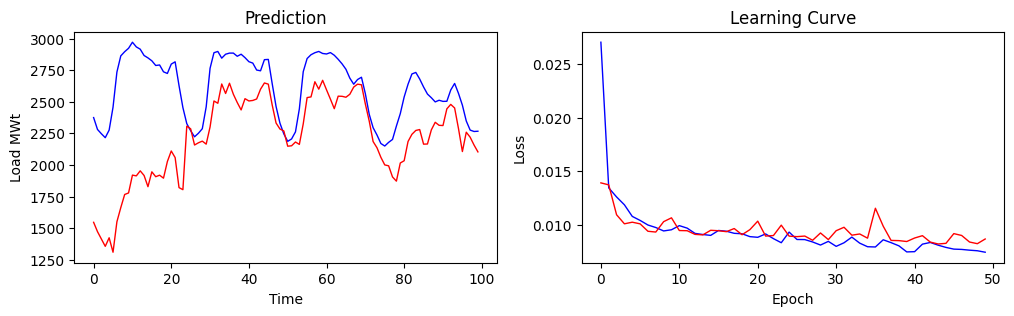



[[1546.6029052734375], [1472.574462890625], [1414.53662109375], [1356.5133056640625], [1424.2314453125], [1310.0323486328125], [1550.9383544921875], [1663.041015625], [1766.6710205078125], [1778.8531494140625], [1920.0096435546875], [1913.834716796875], [1953.7232666015625], [1916.9547119140625], [1828.3001708984375], [1946.041748046875], [1907.3316650390625], [1919.31396484375], [1895.8411865234375], [2027.2359619140625], [2110.724365234375], [2058.673095703125], [1821.0811767578125], [1804.740966796875], [2307.379638671875], [2286.050048828125], [2158.068359375], [2175.5478515625], [2188.588623046875], [2164.956787109375], [2300.77099609375], [2506.264404296875], [2488.076416015625], [2640.62548828125], [2565.633056640625], [2646.69970703125], [2559.611083984375], [2494.107421875], [2435.5556640625], [2524.508056640625], [2506.443359375], [2510.423828125], [2521.998779296875], [2599.4951171875], [2648.6318359375], [2639.55419921875], [2475.186767578125], [2332.011962890625], [2284.

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Epoch 1/50
15/15 [==============================] - 7s 172ms/step - loss: 0.0559 - val_loss: 0.0437
Epoch 2/50
15/15 [==============================] - 1s 94ms/step - loss: 0.0464 - val_loss: 0.0376
Epoch 3/50
15/15 [==============================] - 1s 92ms/step - loss: 0.0280 - val_loss: 0.0202
Epoch 4/50
15/15 [==============================] - 1s 93ms/step - loss: 0.0201 - val_loss: 0.0172
Epoch 5/50
15/15 [==============================] - 1s 101ms/step - loss: 0.0179 - val_loss: 0.0164
Epoch 6/50
15/15 [==============================] - 2s 125ms/step - loss: 0.0176 - val_loss: 0.0157
Epoch 7/50
15/15 [==============================] - 1s 97ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 8/50
15/15 [==============================] - 1s 94ms/step - loss: 0.0151 - val_loss: 0.0115
Epoch 9/50
15/15 [==============================] - 1s 93ms/step - loss: 0.0181 - val_loss: 0.0143
Epoch 10/50
15/15 [==============================] - 1s 93ms/step - loss: 0.0140 - val_loss: 0.0113
Epoch 

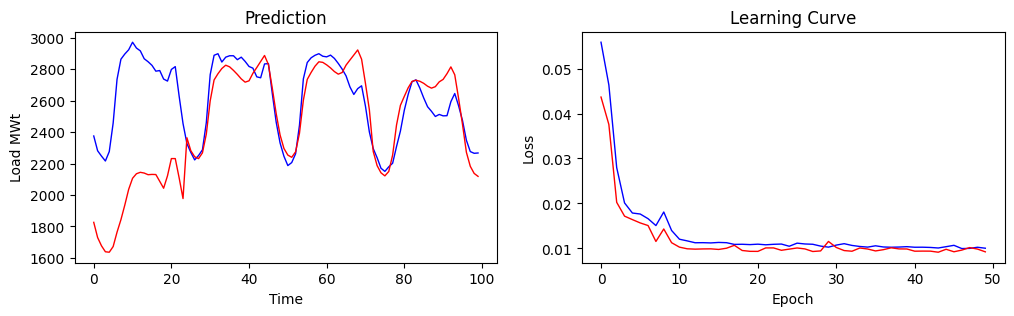



[[1826.12451171875], [1729.5103759765625], [1676.7733154296875], [1639.1070556640625], [1636.2293701171875], [1672.309326171875], [1763.602294921875], [1842.8045654296875], [1935.9036865234375], [2036.126953125], [2106.235107421875], [2135.095703125], [2144.159912109375], [2139.39990234375], [2128.96826171875], [2130.747802734375], [2130.01416015625], [2086.806396484375], [2042.974853515625], [2122.00927734375], [2231.383544921875], [2231.442626953125], [2108.816162109375], [1977.30078125], [2363.791015625], [2281.785888671875], [2243.00830078125], [2231.235107421875], [2267.8427734375], [2387.234130859375], [2598.55615234375], [2731.064453125], [2770.706298828125], [2803.7958984375], [2824.923583984375], [2814.473876953125], [2791.85546875], [2766.31396484375], [2737.919921875], [2717.178466796875], [2725.644775390625], [2773.41650390625], [2810.13525390625], [2848.63818359375], [2886.76416015625], [2828.817626953125], [2678.051513671875], [2517.17529296875], [2381.604248046875], [2

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=1)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 4.DUQ

In [ ]:
path = "/content/drive/MyDrive/DATASETS/DUQ_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()

Xs : (4848, 168, 1), Ys : (4848, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (4848, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


25940

time: 10.2 s (started: 2024-01-27 06:08:52 +00:00)


In [ ]:
print(Yt.tolist())
print("\n")

[[1205.0, 1170.0, 1136.0, 1148.0, 1159.0, 1190.0, 1303.0, 1376.0, 1405.0, 1423.0, 1448.0, 1455.0, 1434.0, 1435.0, 1432.0, 1410.0, 1390.0, 1418.0, 1411.0, 1398.0, 1421.0, 1383.0, 1313.0, 1216.0], [1174.0, 1145.0, 1123.0, 1140.0, 1167.0, 1238.0, 1338.0, 1385.0, 1410.0, 1419.0, 1420.0, 1418.0, 1407.0, 1407.0, 1417.0, 1417.0, 1407.0, 1408.0, 1404.0, 1399.0, 1443.0, 1401.0, 1309.0, 1235.0], [1174.0, 1142.0, 1132.0, 1129.0, 1143.0, 1205.0, 1306.0, 1368.0, 1417.0, 1435.0, 1466.0, 1467.0, 1462.0, 1458.0, 1442.0, 1428.0, 1433.0, 1421.0, 1373.0, 1358.0, 1376.0, 1346.0, 1279.0, 1178.0], [1146.0, 1124.0, 1109.0, 1110.0, 1117.0, 1143.0, 1170.0, 1209.0, 1292.0, 1329.0, 1334.0, 1332.0, 1305.0, 1281.0, 1276.0, 1286.0, 1287.0, 1292.0, 1298.0, 1323.0, 1365.0, 1342.0, 1296.0, 1240.0], [1188.0, 1184.0, 1170.0, 1158.0, 1148.0, 1177.0, 1234.0, 1259.0, 1318.0, 1365.0, 1402.0, 1424.0, 1417.0, 1413.0, 1382.0, 1361.0, 1369.0, 1347.0, 1347.0, 1345.0, 1423.0, 1422.0, 1369.0, 1290.0], [1242.0, 1223.0, 1242.0, 1226

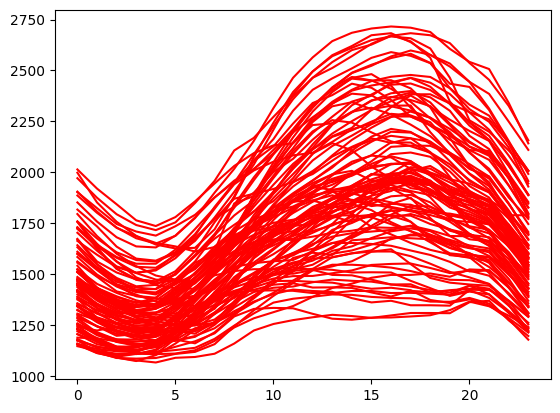

time: 279 ms (started: 2024-01-27 06:09:13 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:02:00
4/4 [==============================] - 1s 12ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 66ms/step

Single Day Inference Time 156.11004829406738 ms

Evaluation metric results:-

MAPE is : 4.836855083703995
R2 is : 0.8919483039935198


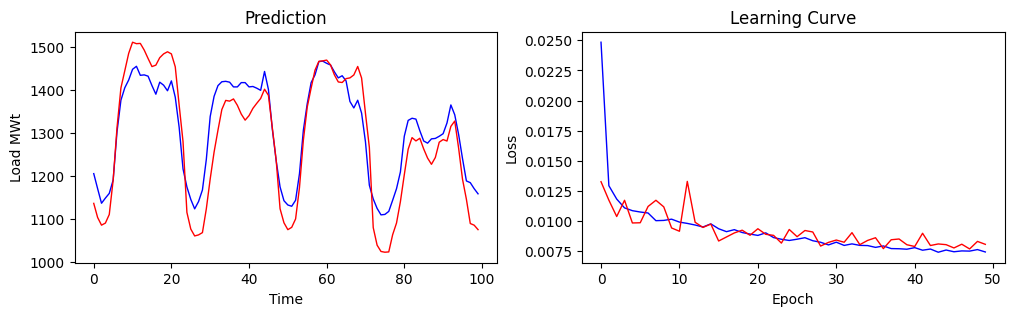



[[1135.733154296875], [1102.872802734375], [1084.9952392578125], [1089.853759765625], [1109.842041015625], [1189.805908203125], [1312.5157470703125], [1404.475830078125], [1444.7052001953125], [1485.1048583984375], [1511.0694580078125], [1507.68408203125], [1508.305908203125], [1492.8543701171875], [1473.11962890625], [1454.3817138671875], [1457.6676025390625], [1475.05322265625], [1483.9271240234375], [1488.8189697265625], [1483.8885498046875], [1453.824462890625], [1364.80615234375], [1279.538330078125], [1114.7135009765625], [1075.9144287109375], [1059.8876953125], [1062.3104248046875], [1067.654541015625], [1122.9334716796875], [1192.6212158203125], [1255.056884765625], [1306.1478271484375], [1354.35205078125], [1375.5562744140625], [1373.8570556640625], [1378.9803466796875], [1364.1131591796875], [1343.6995849609375], [1329.575439453125], [1340.0552978515625], [1356.9925537109375], [1368.8538818359375], [1380.0982666015625], [1401.6400146484375], [1387.445556640625], [1312.02490

In [ ]:
# CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:43
4/4 [==============================] - 0s 5ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 77ms/step

Single Day Inference Time 229.6273708343506 ms

Evaluation metric results:-

MAPE is : 6.2357839196920395
R2 is : 0.8437217735551432


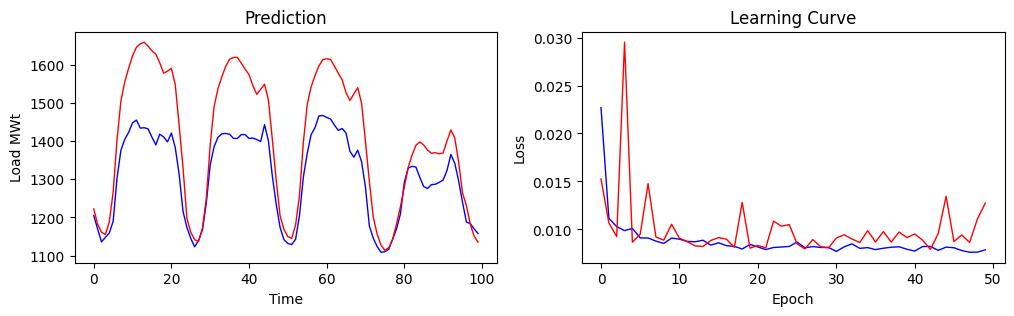



[[1222.25048828125], [1182.4208984375], [1161.4093017578125], [1155.057373046875], [1188.2569580078125], [1266.05908203125], [1403.8209228515625], [1505.14990234375], [1555.4742431640625], [1591.08056640625], [1623.51513671875], [1645.6912841796875], [1654.7650146484375], [1658.9044189453125], [1648.3880615234375], [1636.07373046875], [1627.47265625], [1605.0252685546875], [1578.0120849609375], [1583.0653076171875], [1590.5662841796875], [1547.7525634765625], [1441.3193359375], [1329.90234375], [1197.6927490234375], [1160.8590087890625], [1141.8546142578125], [1137.0626220703125], [1171.9071044921875], [1249.94677734375], [1389.4658203125], [1490.1053466796875], [1537.193359375], [1568.443115234375], [1595.9222412109375], [1614.22412109375], [1619.1796875], [1619.310302734375], [1604.239501953125], [1588.18408203125], [1574.19677734375], [1545.0360107421875], [1522.45556640625], [1535.8446044921875], [1549.0361328125], [1507.5240478515625], [1405.0479736328125], [1298.0693359375], [1

In [ ]:
# 1. ANN

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:21
4/4 [==============================] - 1s 5ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 19ms/step

Single Day Inference Time 60.03403663635254 ms

Evaluation metric results:-

MAPE is : 5.358796566724777
R2 is : 0.8765269426001225


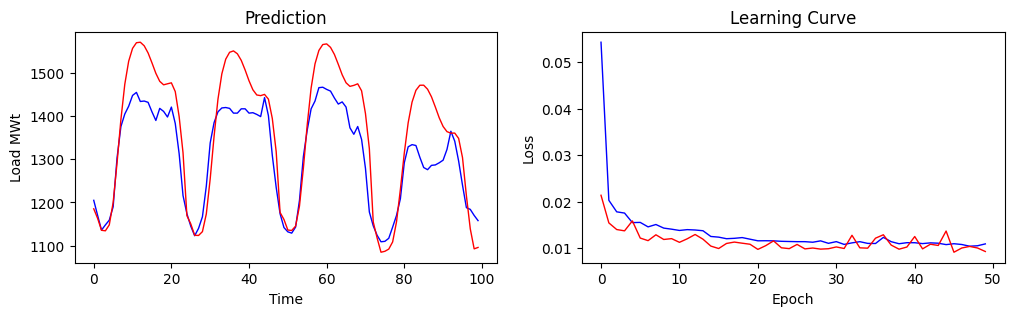



[[1185.324462890625], [1163.1702880859375], [1135.6162109375], [1134.385009765625], [1148.0869140625], [1200.076904296875], [1291.378173828125], [1392.418212890625], [1473.99560546875], [1527.303955078125], [1557.0391845703125], [1570.1068115234375], [1571.265380859375], [1562.976806640625], [1546.3936767578125], [1523.4573974609375], [1499.254638671875], [1480.6864013671875], [1472.58984375], [1474.95849609375], [1477.203125], [1456.9141845703125], [1399.0428466796875], [1315.19873046875], [1169.4599609375], [1150.337646484375], [1124.0443115234375], [1123.59619140625], [1132.46044921875], [1173.48779296875], [1254.711669921875], [1353.39404296875], [1439.19775390625], [1498.0672607421875], [1532.0362548828125], [1547.9608154296875], [1551.156494140625], [1544.4969482421875], [1529.2347412109375], [1506.9078369140625], [1481.9598388671875], [1461.048095703125], [1449.0718994140625], [1447.5196533203125], [1450.4013671875], [1439.373291015625], [1394.5919189453125], [1317.75048828125

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
x = RepeatVector(24)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(1, activation="linear"))(x)
x= Flatten()(x)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:02:31
4/4 [==============================] - 1s 10ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 56ms/step

Single Day Inference Time 136.9342803955078 ms

Evaluation metric results:-

MAPE is : 6.8086035549640656
R2 is : 0.8385638154200834


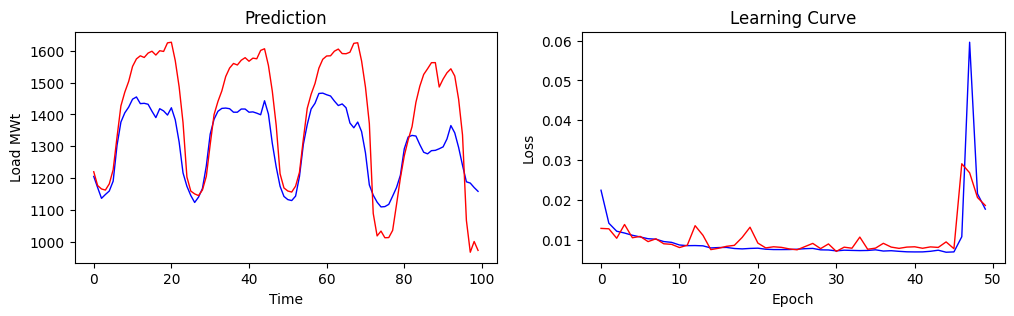



[[1219.5919189453125], [1176.24462890625], [1165.479248046875], [1162.0050048828125], [1181.3818359375], [1225.9569091796875], [1329.011474609375], [1427.020263671875], [1470.0699462890625], [1503.9161376953125], [1551.1220703125], [1574.7593994140625], [1584.4681396484375], [1579.220458984375], [1593.04638671875], [1598.870361328125], [1586.8428955078125], [1600.4324951171875], [1598.260498046875], [1625.2230224609375], [1627.205810546875], [1569.2705078125], [1486.697998046875], [1374.4468994140625], [1203.272216796875], [1158.8074951171875], [1149.9632568359375], [1144.624755859375], [1162.2933349609375], [1205.3173828125], [1305.6485595703125], [1399.7791748046875], [1440.947509765625], [1474.05712890625], [1519.3494873046875], [1545.948486328125], [1560.335693359375], [1555.61376953125], [1570.5316162109375], [1578.6080322265625], [1567.3966064453125], [1577.0826416015625], [1575.12841796875], [1601.513671875], [1606.6363525390625], [1554.1328125], [1473.1746826171875], [1365.98

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(50, return_sequences=True)(inputs)
x = layers.GRU(50, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:43
4/4 [==============================] - 0s 4ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 20ms/step

Single Day Inference Time 61.30409240722656 ms

Evaluation metric results:-

MAPE is : 4.955675080418587
R2 is : 0.8955641672644713


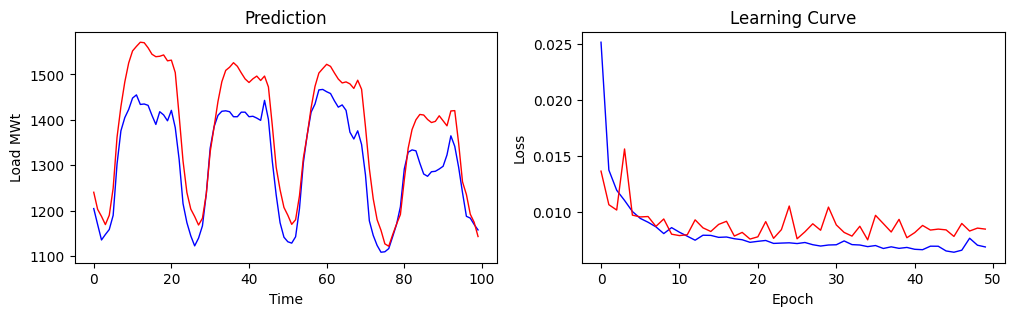



[[1240.8795166015625], [1203.3419189453125], [1187.8201904296875], [1169.810546875], [1190.3641357421875], [1249.643798828125], [1361.74072265625], [1429.436767578125], [1483.427978515625], [1525.1678466796875], [1551.6962890625], [1561.7161865234375], [1570.844482421875], [1569.753173828125], [1558.55859375], [1544.4027099609375], [1539.015380859375], [1539.952392578125], [1542.8748779296875], [1529.9312744140625], [1531.450927734375], [1504.1112060546875], [1409.19287109375], [1309.7171630859375], [1240.19677734375], [1203.8563232421875], [1187.5355224609375], [1168.7763671875], [1183.6351318359375], [1237.5350341796875], [1329.99853515625], [1384.368408203125], [1440.3232421875], [1483.9522705078125], [1508.885498046875], [1515.8909912109375], [1525.8289794921875], [1517.8565673828125], [1503.463623046875], [1490.1046142578125], [1482.261474609375], [1490.3670654296875], [1496.349609375], [1486.724609375], [1496.4034423828125], [1472.4698486328125], [1387.54736328125], [1295.76147

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:01:17
1/1 [==============================] - 0s 366ms/step

Single Day Inference Time 411.99350357055664 ms
4/4 [==============================] - 0s 5ms/step

Evaluation metric results:-

MAPE is : 5.73430135846138
R2 is : 0.8701942136308608


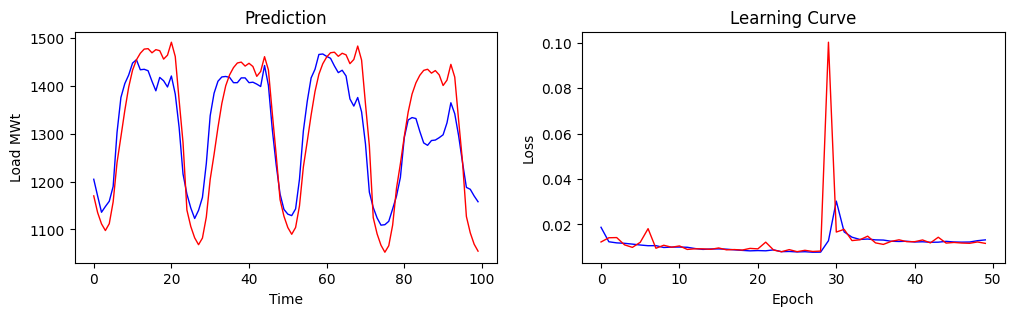



[[1170.2332763671875], [1135.35302734375], [1111.7249755859375], [1097.7421875], [1112.093994140625], [1157.7164306640625], [1239.8876953125], [1293.8602294921875], [1348.7132568359375], [1397.50537109375], [1433.2403564453125], [1454.8319091796875], [1468.5482177734375], [1477.243408203125], [1478.1368408203125], [1469.4727783203125], [1476.079345703125], [1473.9097900390625], [1456.3055419921875], [1464.5128173828125], [1491.607666015625], [1461.677490234375], [1369.796630859375], [1281.76708984375], [1140.6129150390625], [1106.2017822265625], [1082.4996337890625], [1068.1488037109375], [1082.01416015625], [1125.9853515625], [1204.955810546875], [1257.107666015625], [1313.3011474609375], [1363.56396484375], [1400.5467529296875], [1423.39892578125], [1438.4796142578125], [1448.1763916015625], [1450.027099609375], [1441.7042236328125], [1447.5274658203125], [1440.8544921875], [1420.2353515625], [1430.4180908203125], [1461.38037109375], [1433.5970458984375], [1342.5643310546875], [125

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:09:28
4/4 [==============================] - 1s 52ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 46ms/step

Single Day Inference Time 90.02685546875 ms

Evaluation metric results:-

MAPE is : 6.627572327852249
R2 is : 0.8257023988260997


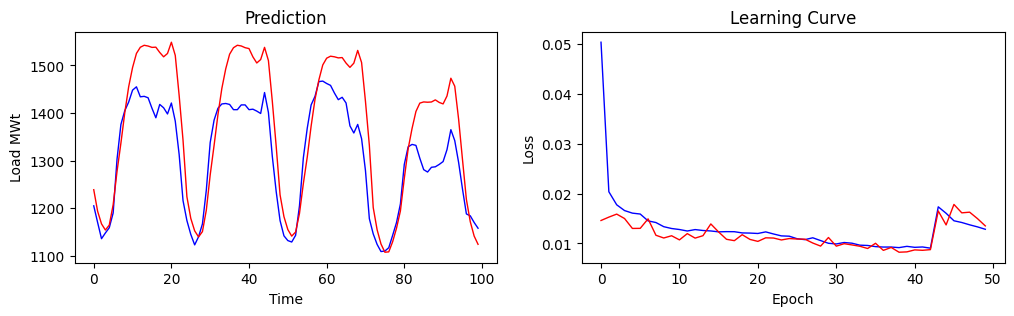



[[1238.8841552734375], [1193.5408935546875], [1167.1199951171875], [1154.2169189453125], [1164.5146484375], [1207.296875], [1277.41455078125], [1336.8355712890625], [1400.8934326171875], [1455.24658203125], [1495.42919921875], [1525.14892578125], [1538.1318359375], [1542.2674560546875], [1540.664306640625], [1537.8477783203125], [1538.27978515625], [1527.1787109375], [1518.0244140625], [1525.0184326171875], [1548.6800537109375], [1521.038330078125], [1437.0126953125], [1343.027587890625], [1224.098388671875], [1178.6236572265625], [1152.45166015625], [1139.7237548828125], [1150.890869140625], [1195.963134765625], [1270.030029296875], [1331.8935546875], [1396.830078125], [1451.58544921875], [1492.7353515625], [1523.478759765625], [1537.140869140625], [1542.299072265625], [1540.8118896484375], [1537.194091796875], [1535.328125], [1517.931884765625], [1505.080810546875], [1512.2745361328125], [1537.896240234375], [1510.137451171875], [1424.745849609375], [1330.1715087890625], [1227.9709

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

# start_time = time.time()
Ys_pred = model.predict(Xts)
# print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 5.EKPC

In [ ]:
path = "/content/drive/MyDrive/DATASETS/EKPC_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()

Xs : (1775, 168, 1), Ys : (1775, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (1775, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


24422

time: 4.47 s (started: 2024-01-27 06:35:31 +00:00)


In [ ]:
print(Yt.tolist())
print("\n")

[[1080.0, 1028.0, 1023.0, 1034.0, 1059.0, 1144.0, 1307.0, 1336.0, 1314.0, 1311.0, 1281.0, 1279.0, 1275.0, 1258.0, 1206.0, 1227.0, 1226.0, 1253.0, 1268.0, 1297.0, 1367.0, 1365.0, 1284.0, 1186.0], [1115.0, 1027.0, 1062.0, 1084.0, 1125.0, 1238.0, 1390.0, 1390.0, 1378.0, 1303.0, 1254.0, 1224.0, 1196.0, 1193.0, 1169.0, 1141.0, 1218.0, 1238.0, 1223.0, 1294.0, 1372.0, 1377.0, 1292.0, 1169.0], [1093.0, 1061.0, 1061.0, 1047.0, 1106.0, 1201.0, 1389.0, 1435.0, 1351.0, 1264.0, 1229.0, 1187.0, 1190.0, 1176.0, 1160.0, 1149.0, 1178.0, 1172.0, 1193.0, 1180.0, 1229.0, 1264.0, 1215.0, 1115.0], [1050.0, 1017.0, 995.0, 1008.0, 1056.0, 1078.0, 1165.0, 1222.0, 1268.0, 1252.0, 1232.0, 1204.0, 1188.0, 1149.0, 1140.0, 1101.0, 1148.0, 1166.0, 1158.0, 1140.0, 1233.0, 1279.0, 1225.0, 1173.0], [1138.0, 1128.0, 1122.0, 1155.0, 1196.0, 1264.0, 1313.0, 1426.0, 1469.0, 1414.0, 1320.0, 1245.0, 1187.0, 1182.0, 1128.0, 1095.0, 1043.0, 1149.0, 1180.0, 1222.0, 1323.0, 1364.0, 1279.0, 1186.0], [1130.0, 1142.0, 1160.0, 1189.

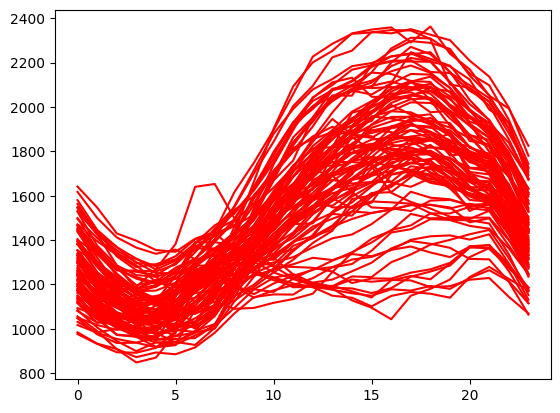

time: 271 ms (started: 2023-12-17 10:04:39 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:00:54
4/4 [==============================] - 1s 7ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 35ms/step

Single Day Inference Time 140.61641693115234 ms

Evaluation metric results:-

MAPE is : 5.244596675038338
R2 is : 0.90196703171705


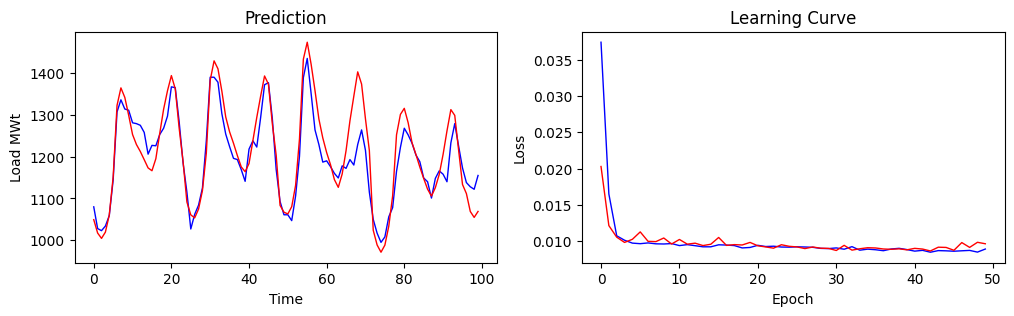



[[1049.355224609375], [1017.3340454101562], [1004.5304565429688], [1019.4676513671875], [1060.527099609375], [1151.1387939453125], [1322.6822509765625], [1364.531982421875], [1341.815185546875], [1298.9295654296875], [1252.9130859375], [1228.98095703125], [1212.3037109375], [1192.8084716796875], [1173.0938720703125], [1166.3360595703125], [1195.128662109375], [1255.62939453125], [1313.4847412109375], [1357.6654052734375], [1393.92431640625], [1362.2310791015625], [1268.3984375], [1189.5303955078125], [1091.477294921875], [1060.749267578125], [1053.587158203125], [1074.5804443359375], [1118.8475341796875], [1208.3294677734375], [1382.73974609375], [1429.169189453125], [1410.136474609375], [1356.90625], [1295.0145263671875], [1259.196533203125], [1232.123779296875], [1202.5682373046875], [1175.4853515625], [1164.075927734375], [1183.5169677734375], [1238.4532470703125], [1293.87255859375], [1345.045654296875], [1393.015380859375], [1373.470703125], [1279.2386474609375], [1203.139892578

In [ ]:
# Proposed CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:17
4/4 [==============================] - 0s 3ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 32ms/step

Single Day Inference Time 85.16740798950195 ms

Evaluation metric results:-

MAPE is : 8.342216163873672
R2 is : 0.7990108803613188


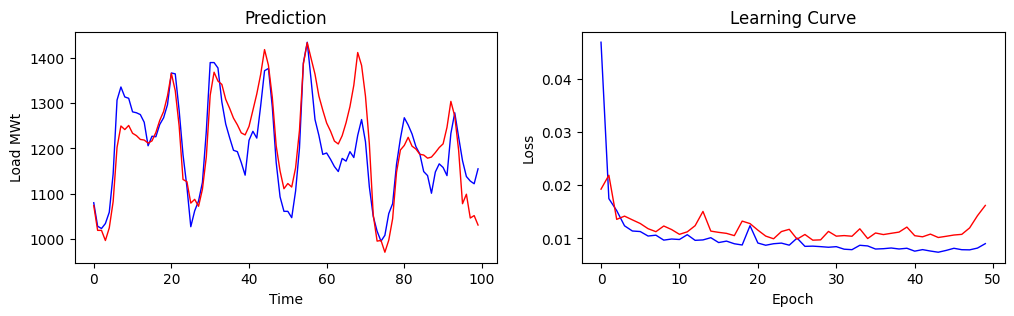



[[1073.751708984375], [1018.923828125], [1018.8619384765625], [996.4978637695312], [1024.3583984375], [1082.6083984375], [1202.3619384765625], [1249.765869140625], [1241.85302734375], [1250.93896484375], [1233.6864013671875], [1228.4156494140625], [1220.03564453125], [1218.609619140625], [1211.8914794921875], [1216.7928466796875], [1235.34912109375], [1262.010009765625], [1281.7978515625], [1316.3062744140625], [1366.0653076171875], [1327.70556640625], [1249.5902099609375], [1131.423583984375], [1126.6627197265625], [1079.175537109375], [1087.5303955078125], [1072.22216796875], [1109.8428955078125], [1181.452392578125], [1317.910400390625], [1368.6539306640625], [1349.0318603515625], [1341.7301025390625], [1308.642822265625], [1288.975830078125], [1267.1494140625], [1252.32470703125], [1234.5399169921875], [1230.0428466796875], [1248.888427734375], [1284.5133056640625], [1320.547607421875], [1363.78125], [1418.694580078125], [1384.0823974609375], [1312.9158935546875], [1205.857910156

In [ ]:
# 1. ANN

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(48, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:11
4/4 [==============================] - 1s 5ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 27ms/step

Single Day Inference Time 69.81587409973145 ms

Evaluation metric results:-

MAPE is : 5.836698040366173
R2 is : 0.8926613242133596


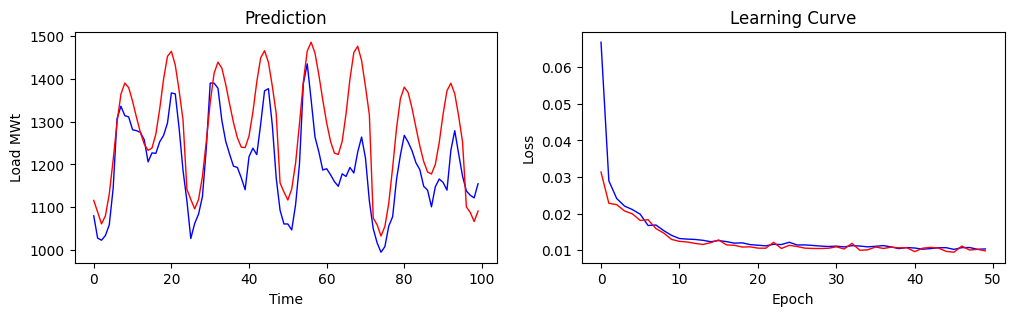



[[1116.0572509765625], [1088.8695068359375], [1061.2181396484375], [1079.8160400390625], [1130.9739990234375], [1210.5712890625], [1297.9813232421875], [1364.041748046875], [1390.1458740234375], [1379.4161376953125], [1347.885498046875], [1310.3896484375], [1275.3958740234375], [1247.765869140625], [1232.9130859375], [1238.3360595703125], [1270.9520263671875], [1330.099853515625], [1400.0888671875], [1452.651611328125], [1464.24658203125], [1432.2021484375], [1372.1993408203125], [1303.837646484375], [1141.7996826171875], [1118.44189453125], [1096.3389892578125], [1118.07080078125], [1171.829833984375], [1253.991455078125], [1344.2957763671875], [1412.7791748046875], [1439.0604248046875], [1424.9822998046875], [1386.9119873046875], [1341.2098388671875], [1297.848388671875], [1262.425537109375], [1240.4171142578125], [1239.2904052734375], [1266.443359375], [1322.406494140625], [1392.705322265625], [1448.9053955078125], [1465.66552734375], [1438.623046875], [1383.097412109375], [1319.0

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
x = RepeatVector(24)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(1, activation="linear"))(x)
x= Flatten()(x)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:37
4/4 [==============================] - 1s 6ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 23ms/step

Single Day Inference Time 61.91539764404297 ms

Evaluation metric results:-

MAPE is : 5.727837979793549
R2 is : 0.8923359391853878


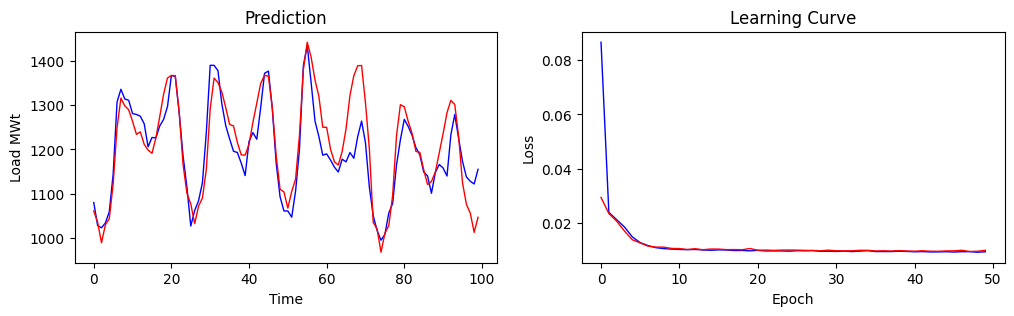



[[1061.0941162109375], [1035.71044921875], [989.123291015625], [1030.0057373046875], [1043.5045166015625], [1121.717041015625], [1248.8839111328125], [1315.9820556640625], [1298.362548828125], [1289.6890869140625], [1263.34033203125], [1234.1153564453125], [1239.596923828125], [1211.4095458984375], [1198.6099853515625], [1191.2718505859375], [1225.549560546875], [1273.853515625], [1325.072265625], [1361.4271240234375], [1366.983154296875], [1366.7513427734375], [1285.114990234375], [1166.7991943359375], [1101.108154296875], [1076.7708740234375], [1032.3673095703125], [1071.7548828125], [1090.2518310546875], [1155.022705078125], [1291.427001953125], [1361.1239013671875], [1350.9974365234375], [1329.810546875], [1294.603515625], [1256.560791015625], [1253.0794677734375], [1215.777587890625], [1187.609130859375], [1187.193115234375], [1211.378662109375], [1261.31103515625], [1304.4000244140625], [1349.0467529296875], [1367.53955078125], [1365.1170654296875], [1294.55224609375], [1185.38

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(100, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.001),loss=mse, metrics=[mse])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:46
4/4 [==============================] - 1s 6ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 29ms/step

Single Day Inference Time 99.00569915771484 ms

Evaluation metric results:-

MAPE is : 6.063538417220116
R2 is : 0.8861589463724286


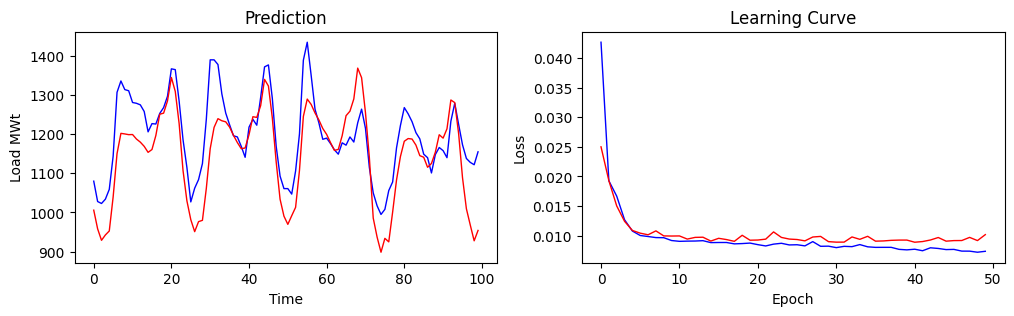



[[1005.9315185546875], [958.2587890625], [928.8968505859375], [942.5796508789062], [952.7183227539062], [1039.972900390625], [1150.380615234375], [1202.1727294921875], [1200.6734619140625], [1198.8558349609375], [1199.1583251953125], [1187.6834716796875], [1179.7183837890625], [1168.9473876953125], [1153.6484375], [1160.8770751953125], [1196.710693359375], [1251.0596923828125], [1253.7841796875], [1285.10498046875], [1344.9718017578125], [1309.35009765625], [1226.8717041015625], [1107.3023681640625], [1029.7442626953125], [981.72998046875], [951.0130004882812], [976.6044921875], [979.9681396484375], [1061.4857177734375], [1162.9718017578125], [1217.408203125], [1239.6859130859375], [1234.3448486328125], [1231.6104736328125], [1218.0406494140625], [1197.0521240234375], [1178.648193359375], [1162.9810791015625], [1164.797607421875], [1198.7513427734375], [1244.6778564453125], [1242.9029541015625], [1272.9444580078125], [1340.03466796875], [1323.1033935546875], [1241.9468994140625], [11

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:25
1/1 [==============================] - 0s 403ms/step

Single Day Inference Time 485.11624336242676 ms
4/4 [==============================] - 0s 5ms/step

Evaluation metric results:-

MAPE is : 5.921157076954842
R2 is : 0.8788361723353469


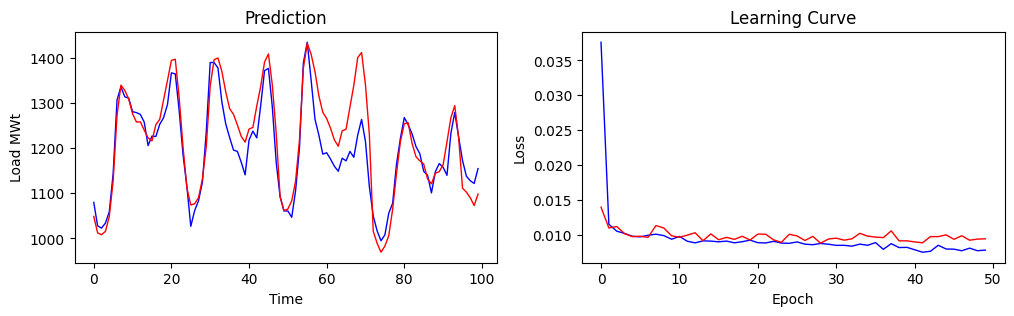



[[1048.9747314453125], [1012.3532104492188], [1008.4091796875], [1015.6242065429688], [1048.384765625], [1127.835693359375], [1273.1834716796875], [1339.8541259765625], [1328.193359375], [1309.47900390625], [1276.438232421875], [1258.1363525390625], [1258.4720458984375], [1240.229736328125], [1223.1072998046875], [1216.2291259765625], [1252.2618408203125], [1264.0887451171875], [1307.6121826171875], [1350.564453125], [1394.6480712890625], [1397.35888671875], [1312.8228759765625], [1202.8631591796875], [1111.6973876953125], [1074.137939453125], [1077.0692138671875], [1090.5941162109375], [1132.128173828125], [1205.0179443359375], [1337.96337890625], [1396.135986328125], [1400.19482421875], [1370.6239013671875], [1325.259521484375], [1287.9044189453125], [1275.2435302734375], [1251.6900634765625], [1226.13720703125], [1213.5743408203125], [1242.399658203125], [1246.1485595703125], [1293.710205078125], [1336.8126220703125], [1391.029052734375], [1409.0203857421875], [1340.4503173828125]

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:05:08
1/1 [==============================] - 2s 2s/step

Single Day Inference Time 1734.7238063812256 ms
4/4 [==============================] - 0s 115ms/step

Evaluation metric results:-

MAPE is : 5.286508426070213
R2 is : 0.8995990463547985


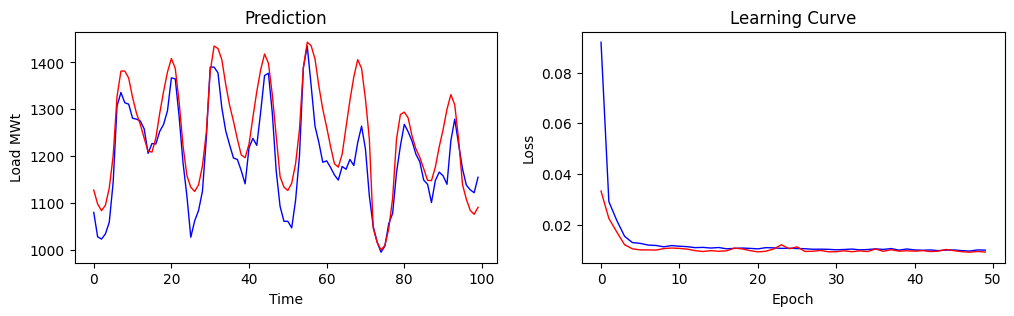



[[1127.500244140625], [1097.9901123046875], [1083.7271728515625], [1095.1446533203125], [1132.085693359375], [1200.60400390625], [1327.4442138671875], [1381.4720458984375], [1381.7147216796875], [1366.6412353515625], [1325.3233642578125], [1291.8834228515625], [1267.54345703125], [1238.1002197265625], [1210.8570556640625], [1208.6168212890625], [1238.7010498046875], [1291.55859375], [1338.5633544921875], [1379.6968994140625], [1408.381103515625], [1387.3203125], [1315.585205078125], [1222.026611328125], [1158.6414794921875], [1133.728759765625], [1124.6468505859375], [1138.822998046875], [1178.873779296875], [1250.59716796875], [1380.4317626953125], [1435.0565185546875], [1429.6988525390625], [1405.790283203125], [1353.056396484375], [1308.5687255859375], [1274.3590087890625], [1236.316162109375], [1202.5201416015625], [1196.71240234375], [1225.4730224609375], [1282.8302001953125], [1337.7666015625], [1384.37353515625], [1417.9423828125], [1398.558837890625], [1331.259033203125], [12

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")
Ys_pred = model.predict(Xts)
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 6.FE

In [ ]:
path = "/content/drive/MyDrive/DATASETS/FE_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()

Xs : (2506, 168, 1), Ys : (2506, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (2506, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


72224

time: 5.73 s (started: 2024-01-27 06:43:27 +00:00)


In [ ]:
print(Yt.tolist())
print("\n")

[[6144.0, 5979.0, 5885.0, 5870.0, 5983.0, 6348.0, 6964.0, 7318.0, 7460.0, 7595.0, 7725.0, 7634.0, 7617.0, 7654.0, 7536.0, 7473.0, 7389.0, 7313.0, 7292.0, 7307.0, 7545.0, 7510.0, 7123.0, 6736.0], [6456.0, 6293.0, 6200.0, 6246.0, 6365.0, 6711.0, 7312.0, 7578.0, 7548.0, 7533.0, 7511.0, 7423.0, 7369.0, 7365.0, 7200.0, 7110.0, 6999.0, 6917.0, 6836.0, 6870.0, 7146.0, 7203.0, 6781.0, 6437.0], [6189.0, 6043.0, 5900.0, 5993.0, 6100.0, 6436.0, 7015.0, 7328.0, 7431.0, 7472.0, 7455.0, 7396.0, 7336.0, 7301.0, 7154.0, 7080.0, 6984.0, 6885.0, 6763.0, 6698.0, 6895.0, 6901.0, 6531.0, 6133.0], [5902.0, 5808.0, 5665.0, 5648.0, 5702.0, 5811.0, 6045.0, 6322.0, 6695.0, 6863.0, 7018.0, 7029.0, 7017.0, 6984.0, 6894.0, 6859.0, 6852.0, 6807.0, 6771.0, 6745.0, 6918.0, 6926.0, 6763.0, 6450.0], [6242.0, 6099.0, 5991.0, 5974.0, 5925.0, 6082.0, 6177.0, 6290.0, 6535.0, 6675.0, 6740.0, 6564.0, 6510.0, 6400.0, 6346.0, 6218.0, 6195.0, 6235.0, 6239.0, 6325.0, 6696.0, 6814.0, 6581.0, 6344.0], [6194.0, 6152.0, 6172.0, 6175

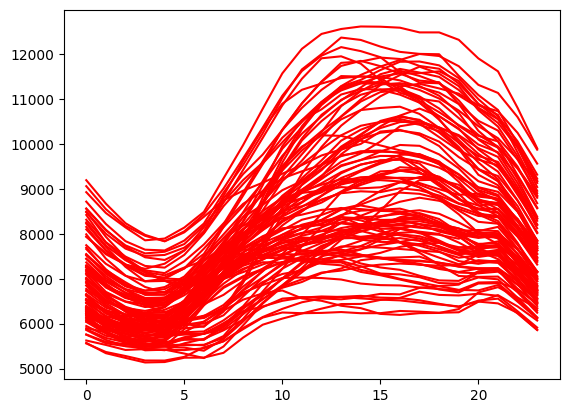

time: 1.15 s (started: 2023-11-27 07:43:17 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:01:28
4/4 [==============================] - 1s 12ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 28ms/step

Single Day Inference Time 101.1803150177002 ms

Evaluation metric results:-

MAPE is : 4.734299331903458
R2 is : 0.8918488769703831


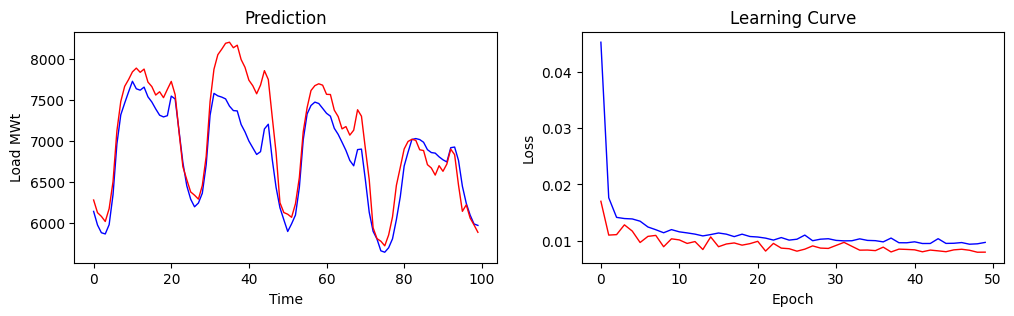



[[6282.34521484375], [6128.66796875], [6083.56494140625], [6021.29052734375], [6177.77490234375], [6505.6142578125], [7122.51513671875], [7480.228515625], [7663.42333984375], [7745.51025390625], [7839.52734375], [7885.12109375], [7833.82275390625], [7873.2734375], [7714.9189453125], [7660.57763671875], [7557.9306640625], [7597.6474609375], [7526.03662109375], [7627.232421875], [7723.630859375], [7562.6953125], [7110.88232421875], [6686.01953125], [6530.20361328125], [6380.5458984375], [6341.06591796875], [6293.0849609375], [6458.3525390625], [6813.30859375], [7478.7041015625], [7870.939453125], [8047.98388671875], [8114.74365234375], [8186.85986328125], [8199.658203125], [8132.66015625], [8163.34423828125], [7989.326171875], [7894.60546875], [7738.33642578125], [7671.0986328125], [7573.23388671875], [7678.8994140625], [7854.1533203125], [7746.60791015625], [7297.23486328125], [6859.9130859375], [6249.9521484375], [6130.22705078125], [6109.6669921875], [6072.2880859375], [6236.8769531

In [ ]:
# Proposed CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:24
4/4 [==============================] - 0s 6ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 68ms/step

Single Day Inference Time 165.3456687927246 ms

Evaluation metric results:-

MAPE is : 5.267274379730225
R2 is : 0.8750823341043311


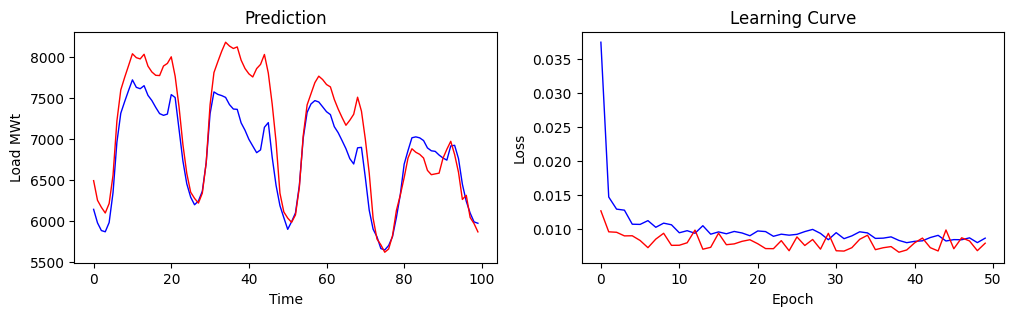



[[6494.37353515625], [6254.61376953125], [6168.767578125], [6099.31298828125], [6215.42724609375], [6560.40380859375], [7223.31689453125], [7602.49755859375], [7756.01318359375], [7898.86474609375], [8043.87548828125], [7996.2138671875], [7980.97412109375], [8037.75830078125], [7893.0400390625], [7821.88330078125], [7780.70703125], [7777.7509765625], [7894.07373046875], [7925.8388671875], [8006.69140625], [7770.37353515625], [7397.384765625], [6936.37939453125], [6583.32763671875], [6353.658203125], [6278.0771484375], [6220.34326171875], [6341.32275390625], [6713.5595703125], [7420.154296875], [7814.32763671875], [7947.58203125], [8075.06005859375], [8184.810546875], [8138.27685546875], [8108.2177734375], [8127.60107421875], [7965.951171875], [7864.14013671875], [7798.59619140625], [7760.59326171875], [7862.8291015625], [7913.763671875], [8035.30419921875], [7808.08837890625], [7430.09814453125], [6968.9130859375], [6341.19140625], [6112.32373046875], [6037.28271484375], [5985.134277

In [ ]:
# 1. ANN

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:13
4/4 [==============================] - 1s 6ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 21ms/step

Single Day Inference Time 63.5068416595459 ms

Evaluation metric results:-

MAPE is : 4.990602657198906
R2 is : 0.8781755916633223


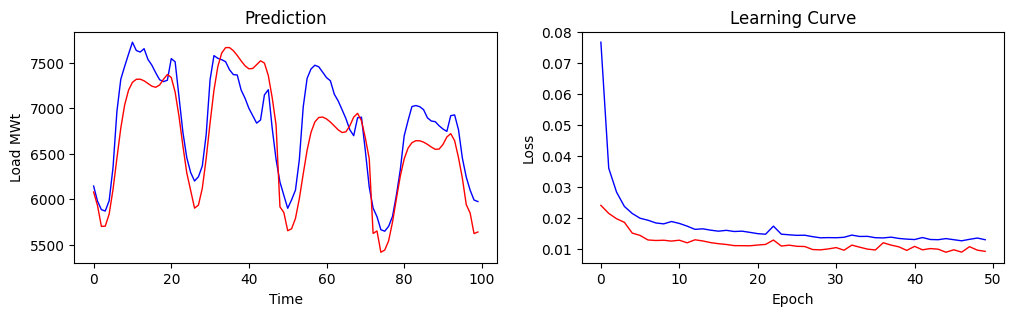



[[6078.83837890625], [5930.9228515625], [5701.14306640625], [5703.53515625], [5836.392578125], [6107.6953125], [6450.20703125], [6780.75537109375], [7036.1474609375], [7198.70849609375], [7284.08740234375], [7317.54150390625], [7319.04248046875], [7300.84423828125], [7271.57421875], [7241.99169921875], [7229.6240234375], [7255.029296875], [7317.90087890625], [7370.41162109375], [7337.52392578125], [7177.1396484375], [6909.05712890625], [6586.03955078125], [6288.4541015625], [6096.013671875], [5901.59375], [5935.07470703125], [6120.4501953125], [6448.0830078125], [6838.533203125], [7197.00830078125], [7457.6748046875], [7606.61328125], [7665.720703125], [7665.9892578125], [7631.95947265625], [7579.6142578125], [7520.419921875], [7466.22802734375], [7432.7451171875], [7436.73779296875], [7478.609375], [7520.39501953125], [7496.10107421875], [7359.1640625], [7116.45166015625], [6815.1171875], [5916.4892578125], [5854.384765625], [5653.53515625], [5674.8876953125], [5788.9697265625], [60

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
x = RepeatVector(24)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(1, activation="linear"))(x)
x= Flatten()(x)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:01:29
4/4 [==============================] - 1s 11ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 104ms/step

Single Day Inference Time 213.26708793640137 ms

Evaluation metric results:-

MAPE is : 5.0661601126194
R2 is : 0.8695197481137279


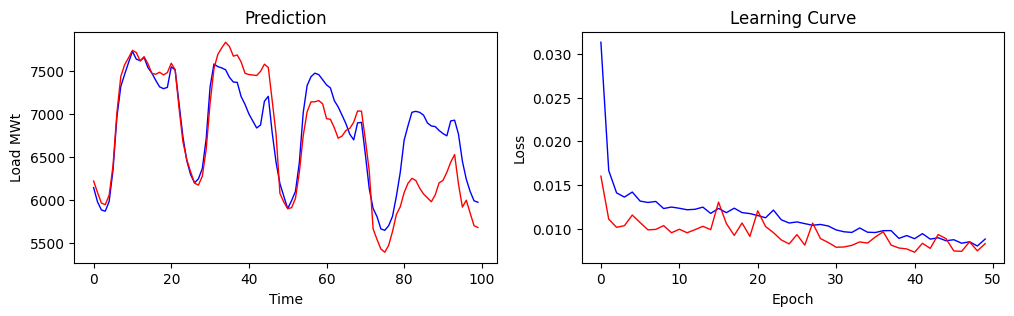



[[6220.1259765625], [6087.625], [5964.55029296875], [5946.4140625], [6054.7392578125], [6399.509765625], [7010.994140625], [7433.35107421875], [7570.80224609375], [7650.1025390625], [7736.77880859375], [7710.6494140625], [7612.68994140625], [7663.4169921875], [7580.2841796875], [7468.7431640625], [7459.88818359375], [7482.62939453125], [7451.55810546875], [7478.8544921875], [7586.9140625], [7512.04248046875], [7070.27685546875], [6677.9716796875], [6468.7236328125], [6325.490234375], [6195.888671875], [6172.7470703125], [6276.37451171875], [6588.3408203125], [7119.4287109375], [7524.056640625], [7690.220703125], [7765.03955078125], [7830.95849609375], [7780.51123046875], [7669.5498046875], [7682.953125], [7602.0361328125], [7471.439453125], [7455.67578125], [7450.47900390625], [7444.44287109375], [7493.0185546875], [7576.09716796875], [7537.81298828125], [7154.62744140625], [6764.25439453125], [6075.49853515625], [5975.74951171875], [5899.32470703125], [5911.0341796875], [6020.043457

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(50, return_sequences=True)(inputs)
x = layers.GRU(50, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:42
4/4 [==============================] - 1s 5ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 30ms/step

Single Day Inference Time 90.99340438842773 ms

Evaluation metric results:-

MAPE is : 5.159222334623337
R2 is : 0.8702209386423858


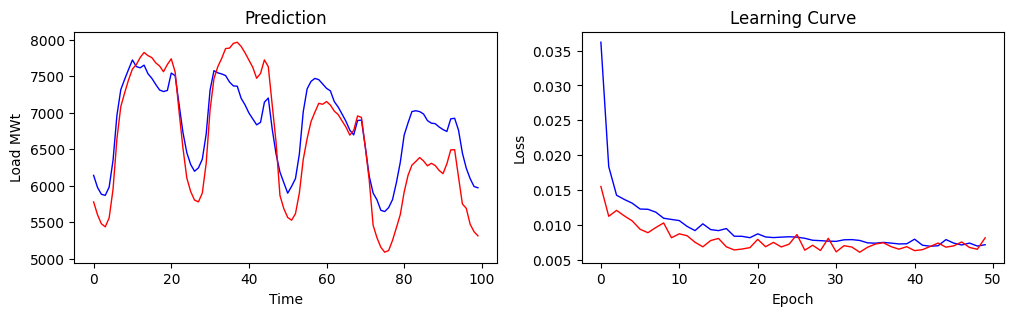



[[5779.861328125], [5604.8310546875], [5480.99072265625], [5438.69580078125], [5561.044921875], [5951.69482421875], [6642.92236328125], [7085.73095703125], [7275.0927734375], [7452.43310546875], [7600.5908203125], [7661.95947265625], [7758.39892578125], [7827.30224609375], [7784.25439453125], [7756.8173828125], [7685.65869140625], [7641.359375], [7563.5625], [7663.0107421875], [7740.4267578125], [7560.24072265625], [7023.61376953125], [6524.65380859375], [6109.94921875], [5921.7626953125], [5805.06689453125], [5780.49267578125], [5900.67041015625], [6310.70703125], [7040.74365234375], [7468.10400390625], [7633.42431640625], [7746.5439453125], [7881.150390625], [7886.41650390625], [7951.76220703125], [7967.69091796875], [7910.45458984375], [7822.73828125], [7723.1787109375], [7624.349609375], [7474.14111328125], [7540.5419921875], [7725.94140625], [7631.74853515625], [7112.16943359375], [6597.19921875], [5868.771484375], [5687.8798828125], [5566.779296875], [5529.32763671875], [5618.8

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:32
1/1 [==============================] - 0s 367ms/step

Single Day Inference Time 448.2443332672119 ms
4/4 [==============================] - 0s 5ms/step

Evaluation metric results:-

MAPE is : 6.472139060497284
R2 is : 0.7996628372050142


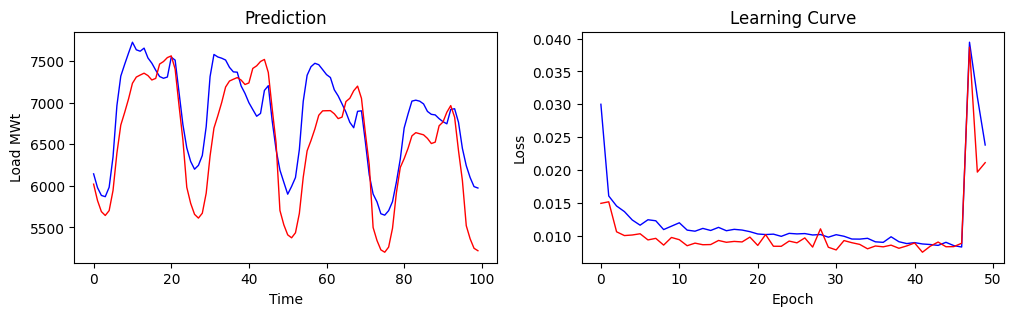



[[6020.29345703125], [5824.1904296875], [5690.755859375], [5644.2587890625], [5702.765625], [5944.62548828125], [6393.150390625], [6730.10791015625], [6882.03662109375], [7044.40478515625], [7231.798828125], [7306.54248046875], [7330.76611328125], [7353.09716796875], [7324.12939453125], [7271.59326171875], [7290.5712890625], [7462.9072265625], [7493.14697265625], [7540.5263671875], [7560.759765625], [7402.90771484375], [6965.69970703125], [6551.85107421875], [5983.19384765625], [5789.93310546875], [5657.9892578125], [5612.7841796875], [5671.509765625], [5912.26513671875], [6359.13037109375], [6693.806640625], [6842.43017578125], [7002.05419921875], [7186.74951171875], [7258.9287109375], [7280.4833984375], [7300.30029296875], [7270.33935546875], [7217.154296875], [7235.96630859375], [7410.025390625], [7441.32373046875], [7493.7392578125], [7518.17236328125], [7361.6474609375], [6926.9296875], [6517.134765625], [5704.18701171875], [5532.298828125], [5411.56640625], [5376.0791015625], [

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:05:24
1/1 [==============================] - 1s 723ms/step

Single Day Inference Time 839.0119075775146 ms
4/4 [==============================] - 0s 53ms/step

Evaluation metric results:-

MAPE is : 5.118533596396446
R2 is : 0.8717523985767182


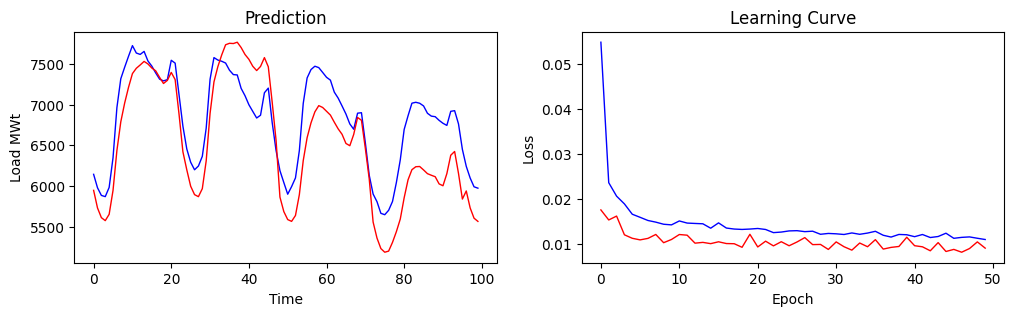



[[5947.1923828125], [5731.22509765625], [5611.71533203125], [5575.23388671875], [5652.5615234375], [5946.572265625], [6437.11181640625], [6788.99169921875], [7020.146484375], [7214.05859375], [7381.57470703125], [7446.7109375], [7487.57958984375], [7531.025390625], [7499.69189453125], [7449.7392578125], [7414.99169921875], [7334.8232421875], [7259.7294921875], [7298.04296875], [7395.81201171875], [7308.2431640625], [6884.56005859375], [6421.271484375], [6199.9189453125], [5997.9560546875], [5894.6611328125], [5869.654296875], [5967.8173828125], [6309.55126953125], [6892.72314453125], [7279.173828125], [7466.04052734375], [7610.9091796875], [7735.38916015625], [7753.66552734375], [7750.6884765625], [7766.81787109375], [7701.50537109375], [7616.27294921875], [7557.04931640625], [7471.380859375], [7418.7529296875], [7469.2236328125], [7577.84765625], [7465.2412109375], [7030.28369140625], [6561.52099609375], [5864.345703125], [5686.0927734375], [5588.181640625], [5566.15966796875], [563

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')


start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict(Xts)
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 7.NI

In [ ]:
path = "/content/drive/MyDrive/DATASETS/NI_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()

Xs : (2322, 168, 1), Ys : (2322, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (2322, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


86439

time: 1.92 s (started: 2024-01-27 06:55:45 +00:00)


In [ ]:
print(Yt.tolist())
print("\n")

[[10451.0, 9795.0, 9437.0, 9160.0, 9071.0, 9292.0, 10001.0, 11315.0, 12137.0, 12852.0, 13523.0, 14327.0, 15076.0, 15834.0, 16369.0, 16608.0, 16708.0, 16639.0, 16175.0, 15879.0, 16139.0, 15857.0, 15097.0, 13930.0], [12722.0, 11799.0, 11213.0, 10838.0, 10632.0, 10683.0, 11210.0, 12341.0, 13005.0, 13232.0, 13047.0, 12809.0, 12561.0, 12456.0, 12595.0, 12658.0, 12591.0, 12406.0, 12037.0, 11713.0, 12063.0, 11783.0, 11288.0, 10496.0], [9776.0, 9055.0, 8633.0, 8307.0, 8152.0, 8117.0, 8341.0, 8678.0, 8896.0, 9345.0, 9703.0, 9933.0, 9997.0, 9942.0, 9784.0, 9672.0, 9569.0, 9506.0, 9595.0, 9872.0, 10246.0, 10089.0, 9778.0, 9268.0], [8734.0, 8220.0, 7928.0, 7663.0, 7596.0, 7520.0, 7654.0, 7827.0, 7842.0, 8314.0, 8646.0, 8954.0, 9076.0, 9153.0, 9159.0, 9094.0, 9124.0, 9154.0, 9312.0, 9616.0, 10176.0, 10095.0, 9684.0, 9145.0], [8521.0, 8115.0, 7895.0, 7758.0, 7837.0, 7985.0, 8628.0, 9910.0, 10636.0, 10972.0, 11190.0, 11362.0, 11434.0, 11482.0, 11503.0, 11477.0, 11409.0, 11286.0, 11142.0, 11287.0, 117

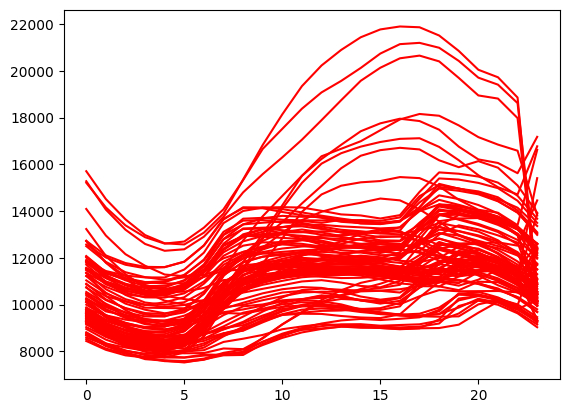

In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:01:03
4/4 [==============================] - 1s 13ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 94ms/step

Single Day Inference Time 245.03779411315918 ms

Evaluation metric results:-

MAPE is : 5.15170656144619
R2 is : 0.8165239863468363


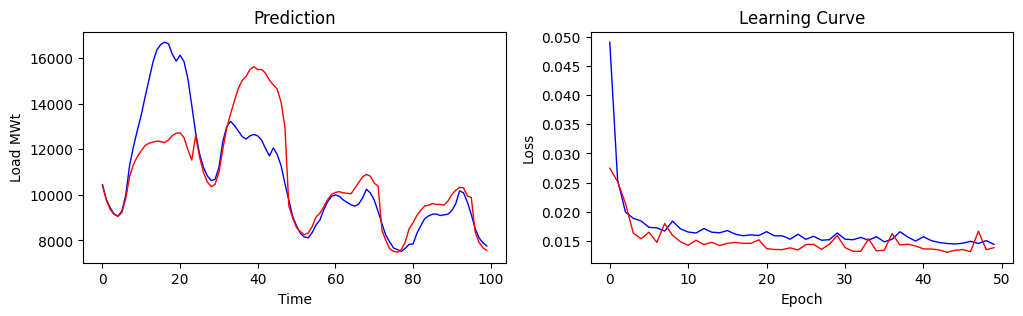



[[10395.6875], [9766.5009765625], [9354.0810546875], [9140.4296875], [9055.59765625], [9232.80859375], [9847.6533203125], [10820.171875], [11351.6318359375], [11691.91015625], [11941.2998046875], [12172.7802734375], [12271.908203125], [12319.0341796875], [12363.1162109375], [12341.70703125], [12296.853515625], [12411.60546875], [12606.0751953125], [12710.6796875], [12723.083984375], [12514.587890625], [11984.2431640625], [11532.9013671875], [12601.6162109375], [11666.5224609375], [10994.8603515625], [10570.6552734375], [10365.232421875], [10464.3115234375], [10991.94140625], [12012.8076171875], [12923.1728515625], [13568.4169921875], [14136.787109375], [14684.716796875], [15025.642578125], [15216.7744140625], [15513.7109375], [15629.6162109375], [15505.7900390625], [15509.859375], [15347.1416015625], [15043.4912109375], [14833.1201171875], [14650.201171875], [14074.5068359375], [12973.595703125], [9516.8349609375], [8985.806640625], [8560.08984375], [8382.548828125], [8250.6884765625

In [ ]:
# Proposed CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:42
4/4 [==============================] - 0s 6ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 100ms/step

Single Day Inference Time 238.47532272338867 ms

Evaluation metric results:-

MAPE is : 8.914018422365189
R2 is : 0.6173061966209603


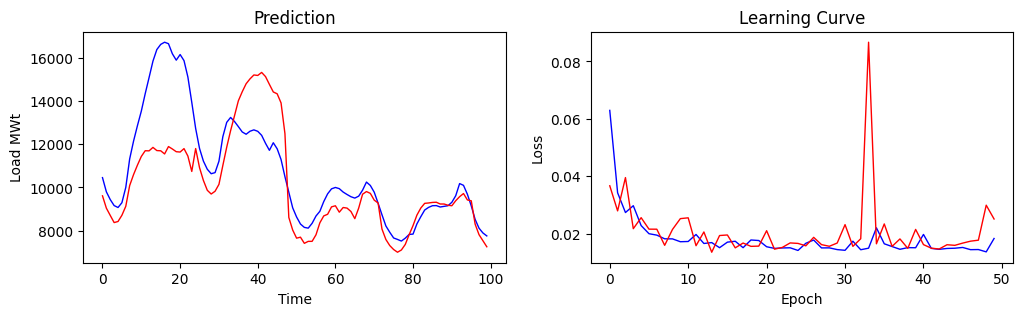



[[9610.00390625], [9039.6376953125], [8704.666015625], [8374.49609375], [8424.126953125], [8712.1689453125], [9126.40625], [10084.171875], [10590.24609375], [11027.9375], [11428.6923828125], [11694.31640625], [11688.4765625], [11848.3125], [11701.7890625], [11691.55859375], [11545.3916015625], [11886.80859375], [11774.5009765625], [11649.0263671875], [11633.7548828125], [11792.3330078125], [11446.6513671875], [10737.0263671875], [11794.4677734375], [10910.529296875], [10319.50390625], [9866.34375], [9693.8291015625], [9821.296875], [10139.7451171875], [11010.685546875], [11857.09375], [12620.044921875], [13304.7470703125], [14001.2626953125], [14419.8515625], [14789.0146484375], [15014.88671875], [15194.9013671875], [15173.0576171875], [15312.2724609375], [15119.580078125], [14759.623046875], [14409.8701171875], [14324.470703125], [13902.669921875], [12484.447265625], [8611.78515625], [8029.04052734375], [7654.53515625], [7699.37255859375], [7415.6357421875], [7506.03955078125], [750

In [ ]:
# 1. ANN

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:26
4/4 [==============================] - 2s 8ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 39ms/step

Single Day Inference Time 150.54726600646973 ms

Evaluation metric results:-

MAPE is : 6.017101928591728
R2 is : 0.7716280773484383


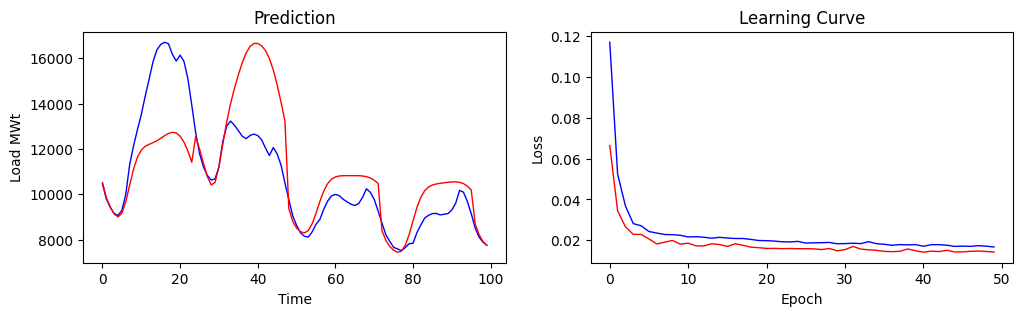



[[10522.25390625], [9852.263671875], [9433.875], [9136.236328125], [9007.2275390625], [9167.4736328125], [9673.619140625], [10404.3916015625], [11115.8046875], [11639.580078125], [11953.7294921875], [12117.462890625], [12205.515625], [12276.3798828125], [12362.271484375], [12469.9443359375], [12586.4501953125], [12686.0126953125], [12736.4140625], [12704.8515625], [12563.86328125], [12297.826171875], [11908.4482421875], [11414.7763671875], [12545.0478515625], [11999.990234375], [11387.8916015625], [10792.7158203125], [10414.5126953125], [10525.8857421875], [11222.365234375], [12222.4404296875], [13190.900390625], [14003.927734375], [14677.9609375], [15270.5498046875], [15802.236328125], [16234.275390625], [16520.1171875], [16652.603515625], [16655.90625], [16551.2890625], [16336.3447265625], [15988.0390625], [15483.9443359375], [14828.6181640625], [14060.544921875], [13224.693359375], [9382.9091796875], [8807.662109375], [8515.083984375], [8356.49609375], [8300.1845703125], [8401.577

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
x = RepeatVector(24)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(1, activation="linear"))(x)
x= Flatten()(x)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:01:27
4/4 [==============================] - 1s 11ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 47ms/step

Single Day Inference Time 124.27401542663574 ms

Evaluation metric results:-

MAPE is : 6.73985555768013
R2 is : 0.7448423982875831


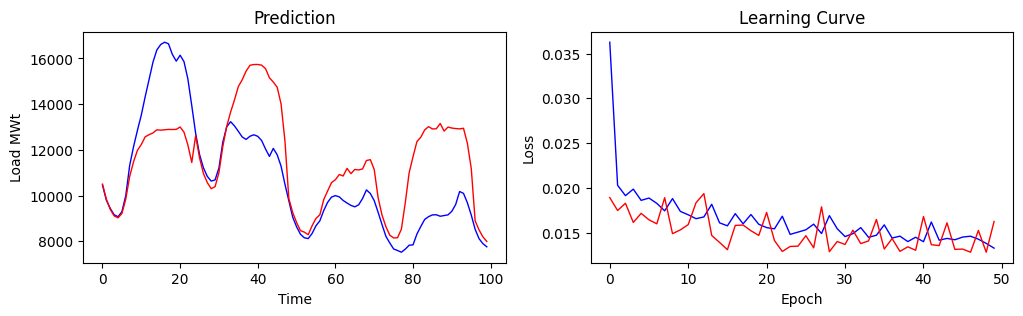



[[10498.0], [9837.529296875], [9392.4287109375], [9110.6787109375], [9025.515625], [9213.1396484375], [9846.818359375], [10832.482421875], [11475.783203125], [11978.18359375], [12234.7421875], [12568.6376953125], [12663.5830078125], [12738.8125], [12875.7822265625], [12859.96875], [12877.3408203125], [12893.82421875], [12888.302734375], [12895.2177734375], [12998.8056640625], [12769.9912109375], [12210.35546875], [11446.3232421875], [12620.6171875], [11651.7998046875], [10965.91015625], [10566.1396484375], [10299.5087890625], [10387.666015625], [11006.861328125], [12149.978515625], [13027.654296875], [13649.4619140625], [14182.470703125], [14770.4921875], [15068.3408203125], [15444.1708984375], [15700.267578125], [15731.734375], [15734.875], [15704.5498046875], [15553.33984375], [15153.189453125], [14964.4931640625], [14738.9228515625], [14008.115234375], [12394.5087890625], [9868.7041015625], [9259.908203125], [8820.16015625], [8463.740234375], [8398.9501953125], [8285.3720703125], 

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(50, return_sequences=True)(inputs)
x = layers.GRU(50, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:37
4/4 [==============================] - 1s 44ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 45ms/step

Single Day Inference Time 117.33055114746094 ms

Evaluation metric results:-

MAPE is : 5.283248424530029
R2 is : 0.8063994974794447


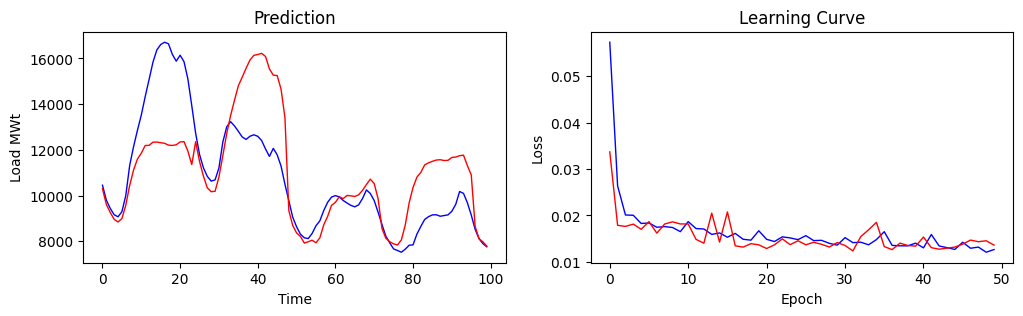



[[10295.90625], [9606.09375], [9259.96875], [8961.111328125], [8842.2275390625], [8993.3212890625], [9576.6591796875], [10441.2236328125], [11113.916015625], [11595.646484375], [11854.85546875], [12190.833984375], [12195.564453125], [12335.453125], [12339.9580078125], [12312.63671875], [12284.2744140625], [12206.03125], [12191.7548828125], [12221.1982421875], [12345.333984375], [12356.5537109375], [11942.6123046875], [11354.544921875], [12358.119140625], [11490.189453125], [10847.71875], [10337.0634765625], [10167.9111328125], [10184.9443359375], [10812.978515625], [11745.140625], [12710.1640625], [13499.2841796875], [14165.3984375], [14803.0341796875], [15181.40234375], [15572.0830078125], [15930.263671875], [16134.3564453125], [16171.3125], [16221.3623046875], [16084.3662109375], [15540.5771484375], [15267.984375], [15250.068359375], [14652.8203125], [13413.3720703125], [9343.73046875], [8692.2373046875], [8364.810546875], [8209.3291015625], [7920.5966796875], [7978.54443359375], [

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:31
1/1 [==============================] - 1s 578ms/step

Single Day Inference Time 641.1972045898438 ms
4/4 [==============================] - 0s 6ms/step

Evaluation metric results:-

MAPE is : 5.2471574395895
R2 is : 0.8120256359058092


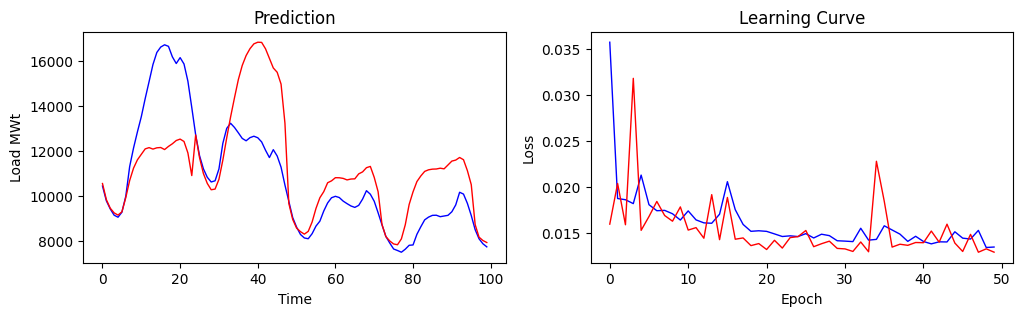



[[10562.5517578125], [9846.33203125], [9469.326171875], [9262.6123046875], [9164.7548828125], [9308.9580078125], [9938.7216796875], [10696.765625], [11245.8349609375], [11613.4873046875], [11856.0234375], [12097.134765625], [12152.84765625], [12088.15234375], [12144.6708984375], [12158.181640625], [12067.8544921875], [12207.3798828125], [12323.400390625], [12468.5419921875], [12530.6962890625], [12425.2841796875], [11918.4267578125], [10915.5986328125], [12713.6640625], [11709.3154296875], [11004.4169921875], [10566.44140625], [10287.259765625], [10315.6591796875], [10748.943359375], [11598.8388671875], [12584.642578125], [13512.318359375], [14358.3876953125], [15168.4677734375], [15792.87890625], [16231.0927734375], [16537.32421875], [16749.349609375], [16821.78515625], [16813.982421875], [16530.474609375], [16106.5380859375], [15681.8603515625], [15491.271484375], [14966.5166015625], [13236.3740234375], [9682.5361328125], [8972.7646484375], [8589.9580078125], [8430.9091796875], [83

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:05:26
1/1 [==============================] - 1s 735ms/step

Single Day Inference Time 782.8421592712402 ms
4/4 [==============================] - 0s 54ms/step

Evaluation metric results:-

MAPE is : 5.5476609617471695
R2 is : 0.7963775212867616


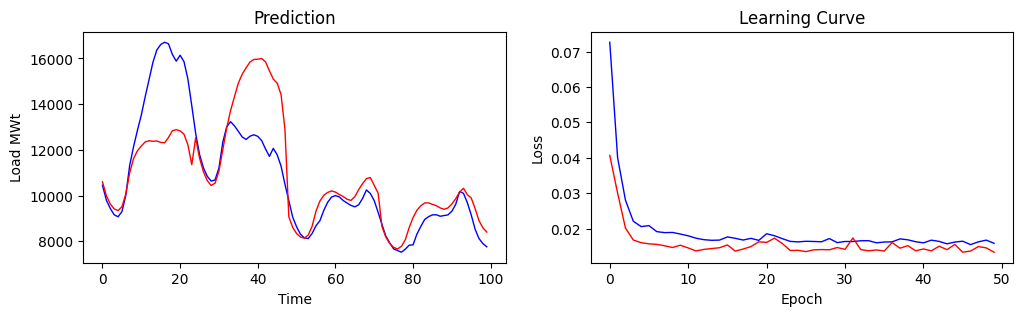



[[10599.603515625], [9992.2578125], [9629.6494140625], [9415.341796875], [9343.25390625], [9506.2099609375], [10059.041015625], [10990.48828125], [11614.923828125], [11959.5908203125], [12167.0244140625], [12348.3095703125], [12395.4326171875], [12375.296875], [12384.828125], [12324.05078125], [12309.390625], [12540.48828125], [12836.5849609375], [12880.5537109375], [12830.1689453125], [12679.4013671875], [12219.4248046875], [11347.3515625], [12524.62890625], [11641.466796875], [11044.78125], [10648.00390625], [10441.662109375], [10540.91796875], [11066.78125], [12013.126953125], [12965.599609375], [13721.5693359375], [14326.7109375], [14919.0439453125], [15313.3037109375], [15588.267578125], [15844.6318359375], [15953.9873046875], [15965.9501953125], [15993.78125], [15849.6845703125], [15457.099609375], [15096.392578125], [14917.4677734375], [14417.767578125], [12898.484375], [9073.84375], [8606.9306640625], [8337.9033203125], [8182.806640625], [8134.76171875], [8270.38671875], [865

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")
Ys_pred = model.predict(Xts)
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 8.PJME

In [ ]:
path = "/content/drive/MyDrive/DATASETS/PJME_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()

Xs : (5942, 168, 1), Ys : (5942, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (5942, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


78220

time: 1.86 s (started: 2024-01-27 07:07:13 +00:00)


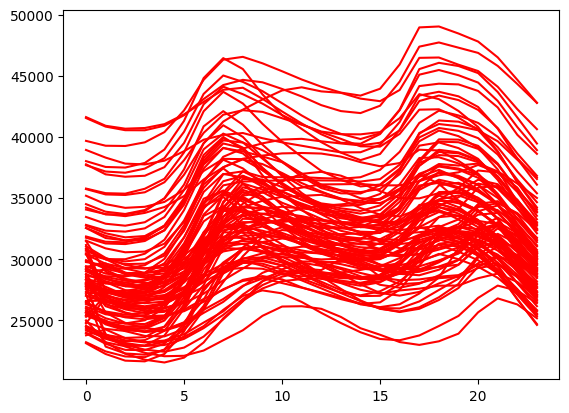

time: 337 ms (started: 2024-01-24 07:22:03 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:02:30
4/4 [==============================] - 1s 10ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 30ms/step

Single Day Inference Time 89.72311019897461 ms

Evaluation metric results:-

MAPE is : 5.492405593395233
R2 is : 0.7919358736204634


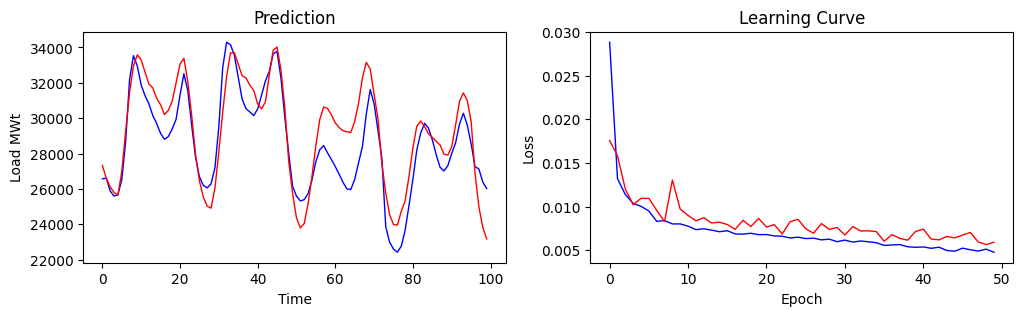



[[27331.56640625], [26610.369140625], [26117.03515625], [25803.013671875], [25633.814453125], [26994.169921875], [29250.189453125], [31432.990234375], [32936.1953125], [33581.65625], [33295.40625], [32597.033203125], [31936.68359375], [31706.18359375], [31120.41015625], [30755.384765625], [30203.05859375], [30447.4921875], [30966.380859375], [32008.48828125], [33056.6796875], [33385.22265625], [32069.689453125], [30169.26171875], [27955.119140625], [26465.45703125], [25540.47265625], [25032.810546875], [24913.275390625], [26047.818359375], [28101.65625], [30334.896484375], [32348.056640625], [33688.8046875], [33702.359375], [33056.08984375], [32395.478515625], [32271.900390625], [31862.98046875], [31562.41796875], [30818.423828125], [30517.392578125], [30926.419921875], [32449.220703125], [33844.07421875], [34018.84375], [32735.609375], [30591.71875], [27572.51171875], [25754.884765625], [24368.126953125], [23798.86328125], [24041.23828125], [25165.875], [26703.158203125], [28456.792

In [ ]:
# Proposed CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:42
4/4 [==============================] - 0s 5ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 30ms/step

Single Day Inference Time 112.77961730957031 ms

Evaluation metric results:-

MAPE is : 6.215367093682289
R2 is : 0.7302705774386322


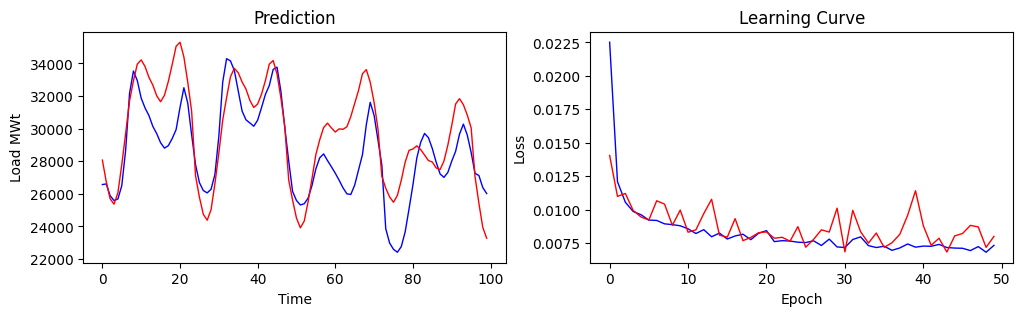



[[28072.677734375], [26747.841796875], [25702.732421875], [25369.56640625], [26064.91796875], [27799.578125], [29710.0703125], [31696.677734375], [32932.00390625], [33959.09765625], [34219.03515625], [33810.45703125], [33145.5], [32673.57421875], [32015.861328125], [31650.57421875], [32049.748046875], [32903.29296875], [33947.7109375], [35051.69140625], [35301.48046875], [34399.3515625], [32845.9375], [31053.6484375], [27113.3125], [25797.84375], [24751.93359375], [24383.98828125], [25028.080078125], [26634.748046875], [28496.740234375], [30523.48828125], [31901.806640625], [33184.98046875], [33698.3984375], [33430.74609375], [32861.51171875], [32426.08203125], [31736.7265625], [31299.44140625], [31510.408203125], [32113.77734375], [32947.2109375], [33952.92578125], [34178.61328125], [33344.0703125], [31871.20703125], [30125.5625], [26854.935546875], [25619.271484375], [24520.2890625], [23918.76953125], [24330.97265625], [25519.013671875], [26932.40625], [28411.6484375], [29324.82226

In [ ]:
# 1. ANN

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:00:45
4/4 [==============================] - 1s 8ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 32ms/step

Single Day Inference Time 153.57208251953125 ms

Evaluation metric results:-

MAPE is : 6.324458867311478
R2 is : 0.7259353060784344


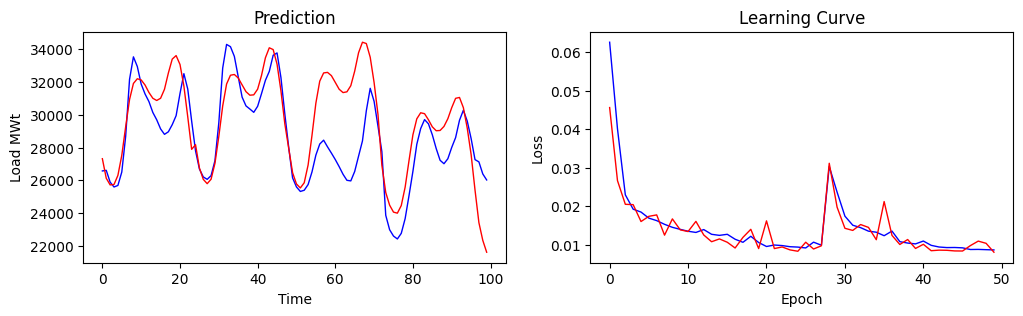



[[27319.009765625], [26127.7421875], [25720.908203125], [25744.453125], [26299.978515625], [27520.021484375], [29261.71875], [30929.220703125], [31910.8203125], [32197.564453125], [32125.314453125], [31813.259765625], [31359.439453125], [31006.46484375], [30872.2421875], [31007.765625], [31554.880859375], [32547.544921875], [33397.6796875], [33611.39453125], [33068.2890625], [31753.4375], [29867.10546875], [27890.994140625], [28174.51171875], [26754.603515625], [26058.20703125], [25796.251953125], [26064.861328125], [27033.47265625], [28682.560546875], [30538.9609375], [31876.15234375], [32413.21484375], [32458.509765625], [32245.0234375], [31823.4140625], [31409.498046875], [31194.541015625], [31216.40625], [31563.60546875], [32402.8828125], [33476.9765625], [34087.98046875], [33978.21484375], [33088.12890625], [31466.154296875], [29452.037109375], [27956.697265625], [26468.203125], [25779.40625], [25533.98046875], [25851.591796875], [26934.826171875], [28741.52734375], [30707.79296

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
x = RepeatVector(24)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = TimeDistributed(Dense(1, activation="linear"))(x)
x= Flatten()(x)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:02:30
4/4 [==============================] - 1s 12ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 64ms/step

Single Day Inference Time 167.41943359375 ms

Evaluation metric results:-

MAPE is : 6.017694994807243
R2 is : 0.7539410376569142


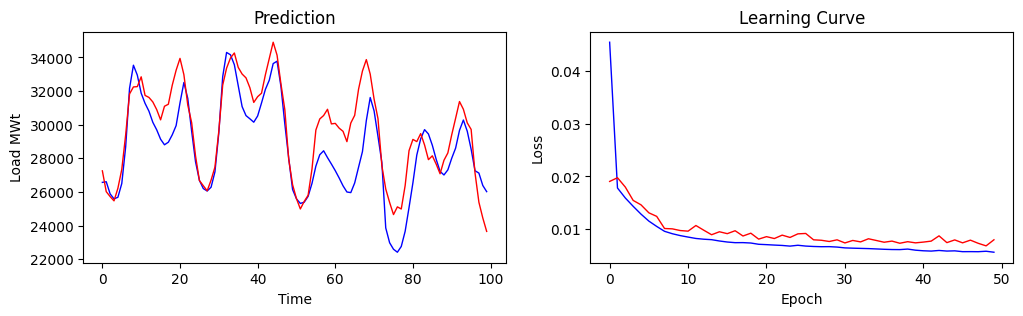



[[27257.216796875], [26020.283203125], [25728.796875], [25474.091796875], [26223.595703125], [27342.888671875], [29393.1875], [31826.458984375], [32244.38671875], [32262.546875], [32845.15234375], [31741.33203125], [31620.138671875], [31351.34765625], [30895.28515625], [30288.365234375], [31096.103515625], [31216.107421875], [32345.48828125], [33236.8984375], [33940.890625], [32973.1328125], [31171.7109375], [30121.09375], [28141.58984375], [26683.25390625], [26375.310546875], [26072.353515625], [26704.556640625], [27480.712890625], [29623.037109375], [32352.703125], [33361.0], [33962.859375], [34262.453125], [33406.15234375], [33011.3125], [32783.40625], [32198.919921875], [31324.533203125], [31665.365234375], [31871.064453125], [32972.75390625], [33937.8515625], [34901.48046875], [34134.5078125], [32428.0703125], [30896.326171875], [27953.611328125], [26438.083984375], [25608.765625], [24993.251953125], [25441.38671875], [25805.208984375], [27363.431640625], [29682.689453125], [303

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(50, return_sequences=True)(inputs)
x = layers.GRU(50, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.001),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Epoch 1/50
149/149 [==============================] - 7s 19ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 2/50
149/149 [==============================] - 2s 15ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 3/50
149/149 [==============================] - 2s 11ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 4/50
149/149 [==============================] - 2s 11ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5/50
149/149 [==============================] - 2s 11ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 6/50
149/149 [==============================] - 1s 9ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 7/50
149/149 [==============================] - 2s 11ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 8/50
149/149 [==============================] - 2s 11ms/step - l

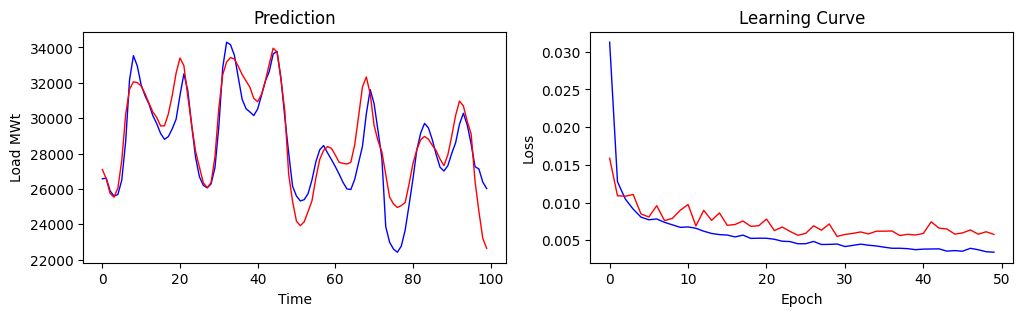



[[27101.609375], [26561.357421875], [25749.232421875], [25532.333984375], [26054.673828125], [27613.90234375], [30211.8125], [31628.947265625], [32058.619140625], [32010.20703125], [31818.650390625], [31381.908203125], [30848.1640625], [30351.265625], [30042.701171875], [29560.177734375], [29568.3203125], [30241.896484375], [31282.3203125], [32555.7734375], [33403.69140625], [32969.86328125], [31260.111328125], [29618.8671875], [28138.5625], [27234.0859375], [26350.072265625], [26075.4453125], [26352.375], [27809.0390625], [30565.55078125], [32450.708984375], [33173.5546875], [33427.6875], [33345.92578125], [32939.96875], [32470.21875], [32109.279296875], [31755.755859375], [31112.552734375], [30933.708984375], [31347.4609375], [32115.3046875], [33065.67578125], [33956.69140625], [33747.3046875], [32190.599609375], [30393.9453125], [26818.451171875], [25294.693359375], [24177.5625], [23921.96484375], [24144.67578125], [24727.373046875], [25331.75], [26616.72265625], [27672.68359375],

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:01:24
1/1 [==============================] - 0s 400ms/step

Single Day Inference Time 450.64568519592285 ms
4/4 [==============================] - 0s 6ms/step

Evaluation metric results:-

MAPE is : 7.849912345409393
R2 is : 0.5980964039068106


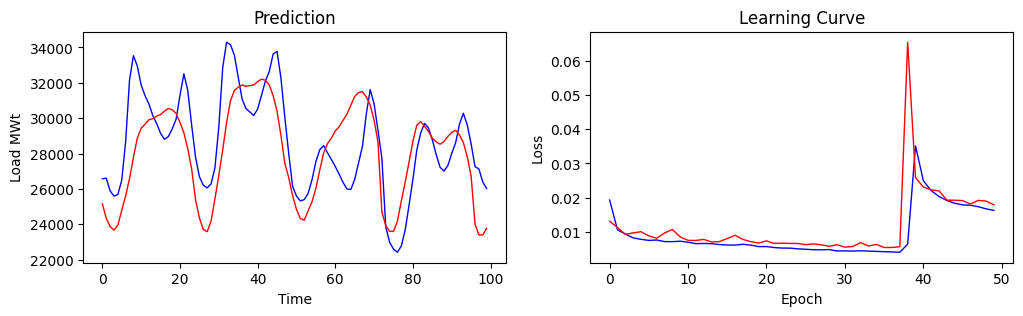



[[25148.748046875], [24342.423828125], [23871.96484375], [23669.640625], [23960.34375], [24801.880859375], [25608.11328125], [26589.984375], [27779.6171875], [28867.95703125], [29427.400390625], [29665.986328125], [29917.216796875], [29973.28515625], [30118.09765625], [30203.53125], [30401.697265625], [30545.4296875], [30477.794921875], [30266.115234375], [29758.041015625], [29173.419921875], [28275.517578125], [27122.52734375], [25402.4453125], [24354.185546875], [23711.326171875], [23580.685546875], [24182.197265625], [25444.013671875], [26758.599609375], [28205.330078125], [29747.419921875], [30977.658203125], [31561.91796875], [31754.8984375], [31876.732421875], [31799.05859375], [31847.546875], [31878.744140625], [32067.18359375], [32208.099609375], [32145.41796875], [31877.90625], [31271.259765625], [30397.537109375], [29028.880859375], [27454.5546875], [26643.744140625], [25632.9765625], [24843.171875], [24328.00390625], [24235.447265625], [24763.509765625], [25267.412109375],

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:10:25
1/1 [==============================] - 1s 706ms/step

Single Day Inference Time 816.7738914489746 ms
4/4 [==============================] - 0s 53ms/step

Evaluation metric results:-

MAPE is : 8.055034279823303
R2 is : 0.5822988884416656


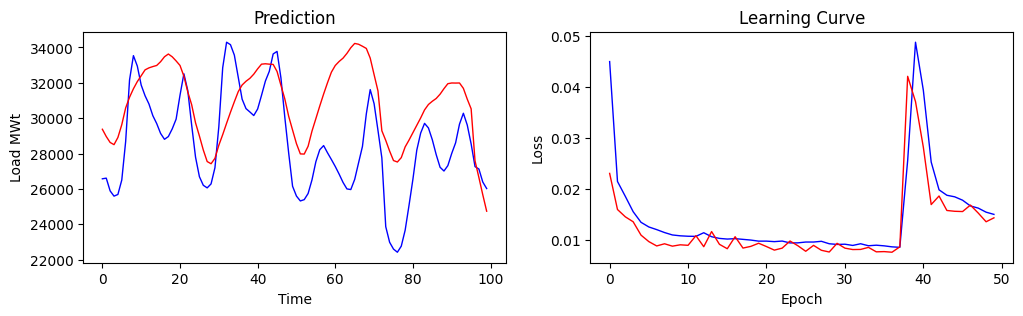



[[29373.44921875], [28963.654296875], [28627.55859375], [28503.1015625], [28908.310546875], [29632.123046875], [30580.140625], [31181.802734375], [31662.806640625], [32067.826171875], [32398.515625], [32731.748046875], [32844.328125], [32917.62890625], [32980.390625], [33193.25390625], [33471.6953125], [33626.5703125], [33469.40625], [33235.9375], [32979.85546875], [32375.58203125], [31488.583984375], [30764.26171875], [29738.74609375], [28991.611328125], [28202.962890625], [27548.685546875], [27423.857421875], [27728.626953125], [28469.025390625], [29069.220703125], [29712.25390625], [30335.576171875], [30929.048828125], [31498.603515625], [31874.912109375], [32087.076171875], [32252.982421875], [32487.880859375], [32789.00390625], [33053.703125], [33075.109375], [33053.83203125], [33039.54296875], [32640.71484375], [31858.263671875], [31087.578125], [30103.59765625], [29328.708984375], [28559.609375], [27980.52734375], [27970.490234375], [28412.337890625], [29269.365234375], [29974

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")
Ys_pred = model.predict(Xts)
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 9.PJMW

In [ ]:
path = "/content/drive/MyDrive/DATASETS/PJMW_hourly.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
# n = round((len(dataset)/24)*0.8)*24
train = dataset.iloc[:-2568,:]
test = dataset.iloc[-2568:,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# # Image Conversion GADF
# transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
# X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
# Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
# print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

Xs_i = Xs.reshape(-1,7,24,1)
Xts_i = Xts.reshape(-1,7,24,1)
print(f"Xs_i : {Xs_i.shape}")
print(f"Xts_i : {Xts_i.shape}")

# Xd = np.insert(Ys, 0, 0, axis=1)
# Xd = np.delete(Xd,-1, axis=1)
# print(f"Xd : {Xd.shape}")

del dataset, train, test, X, Xt
gc.collect()

Xs : (5854, 168, 1), Ys : (5854, 24)
Xts : (100, 168, 1), Yt : (100, 24)
Xs_i : (5854, 7, 24, 1)
Xts_i : (100, 7, 24, 1)


0

time: 20.5 s (started: 2024-01-27 07:23:51 +00:00)


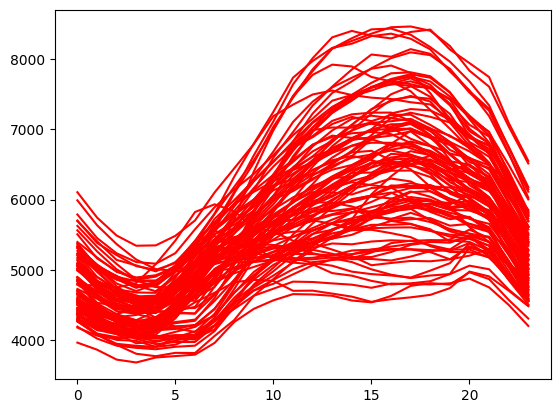

time: 394 ms (started: 2023-12-17 10:06:37 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Training Time : 00:02:28
4/4 [==============================] - 1s 9ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 29ms/step

Single Day Inference Time 91.97115898132324 ms

Evaluation metric results:-

MAPE is : 3.961718827486038
R2 is : 0.8909823644352346


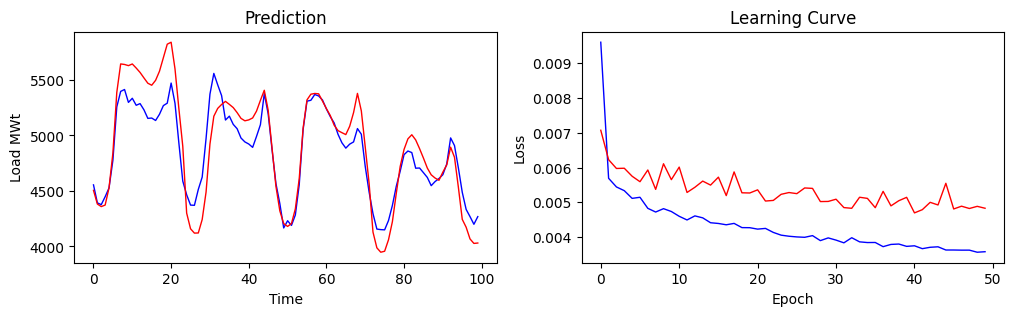



[[4505.50439453125], [4382.3544921875], [4359.396484375], [4373.1640625], [4527.60888671875], [4842.09814453125], [5387.5419921875], [5644.390625], [5639.52587890625], [5629.12841796875], [5643.970703125], [5607.3837890625], [5567.5751953125], [5518.2548828125], [5470.55615234375], [5452.5185546875], [5496.8193359375], [5578.58349609375], [5700.34375], [5822.2138671875], [5839.91259765625], [5599.0751953125], [5239.6728515625], [4903.173828125], [4300.95947265625], [4159.64208984375], [4120.5439453125], [4121.8291015625], [4242.900390625], [4490.4833984375], [4922.484375], [5173.27978515625], [5243.78125], [5279.3232421875], [5307.06103515625], [5280.08349609375], [5251.21630859375], [5205.9365234375], [5153.93212890625], [5132.17626953125], [5140.3056640625], [5157.75634765625], [5219.58740234375], [5316.30615234375], [5407.19482421875], [5227.63671875], [4885.2607421875], [4542.30908203125], [4321.21630859375], [4206.5732421875], [4180.89892578125], [4205.96142578125], [4339.226074

In [ ]:
# Proposed CNNLSTM+GAF

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
x2 = layers.GlobalAvgPool2D()(x2)
c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(c1)

model = Model([seq_inputs,img_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict([Xts,Xt_img])
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xt_img[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:01:24
4/4 [==============================] - 0s 3ms/step

Total Inference Time : 00:00:00
1/1 [==============================] - 0s 32ms/step

Single Day Inference Time 92.82374382019043 ms

Evaluation metric results:-

MAPE is : 4.412872344255447
R2 is : 0.8814799523250594


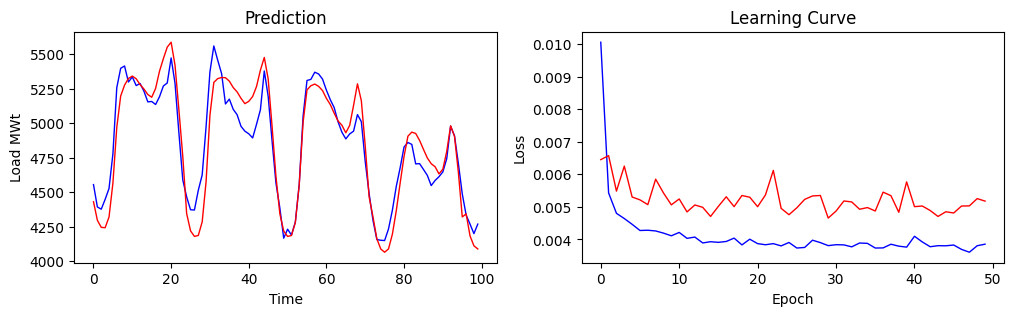



[[4430.921875], [4296.4716796875], [4245.5078125], [4242.7236328125], [4320.27880859375], [4565.00830078125], [4969.8857421875], [5196.0712890625], [5275.474609375], [5323.47509765625], [5340.88720703125], [5321.341796875], [5279.53857421875], [5246.83251953125], [5207.28369140625], [5187.56787109375], [5251.40966796875], [5375.73291015625], [5466.859375], [5550.5478515625], [5586.0576171875], [5420.0166015625], [5096.3017578125], [4759.77197265625], [4345.52490234375], [4220.115234375], [4179.89013671875], [4186.66015625], [4285.0888671875], [4575.21728515625], [5058.3720703125], [5295.26220703125], [5322.373046875], [5330.6904296875], [5329.013671875], [5304.05322265625], [5257.6455078125], [5226.18310546875], [5179.81005859375], [5141.26806640625], [5157.81982421875], [5192.9072265625], [5265.49951171875], [5383.9052734375], [5475.876953125], [5320.14306640625], [4977.6826171875], [4615.2236328125], [4344.82861328125], [4219.10400390625], [4179.6845703125], [4186.42041015625], [42

In [ ]:
# 1. ANN

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(48, activation="relu")(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="MLP")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Inputs : (None, 168, 1)
LSTM+DROPOUT : (None, 50)
REPEAT VECTOR : (None, 24, 50)
LSTM2+DROPOUT : (None, 24, 50)
TIME DISTRIBUTED : (None, 24, 1)
OUTPUT : (None, 24)
Training Time : 00:00:45
4/4 [==============================] - 2s 9ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 29ms/step

Single Day Inference Time 99.89213943481445 ms

Evaluation metric results:-

MAPE is : 4.246317222714424
R2 is : 0.8867608924895696


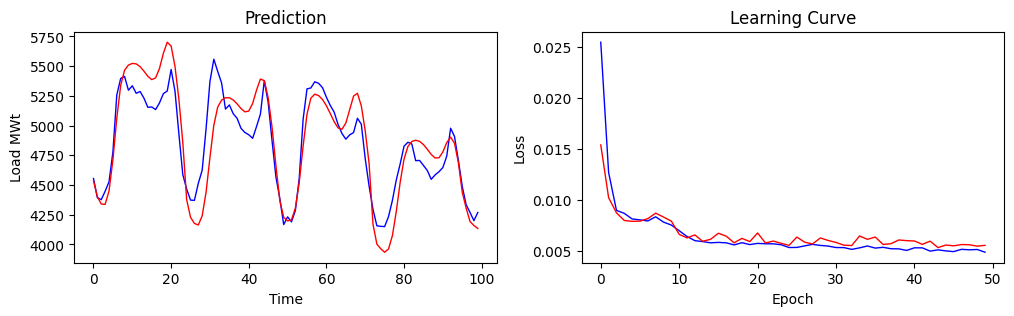



[[4535.91796875], [4401.3544921875], [4340.15185546875], [4337.12646484375], [4449.9892578125], [4711.439453125], [5062.0703125], [5337.708984375], [5465.931640625], [5509.4365234375], [5523.505859375], [5519.5625], [5496.615234375], [5457.90576171875], [5414.7919921875], [5387.06640625], [5401.4482421875], [5480.7939453125], [5608.69970703125], [5701.80517578125], [5669.51123046875], [5497.509765625], [5220.9755859375], [4861.16796875], [4376.92333984375], [4228.166015625], [4176.74609375], [4163.54638671875], [4240.48486328125], [4438.93701171875], [4732.76611328125], [5003.19970703125], [5155.63671875], [5214.912109375], [5234.57763671875], [5234.3447265625], [5216.02734375], [5182.5439453125], [5143.53076171875], [5115.78857421875], [5122.63427734375], [5186.40576171875], [5299.0009765625], [5392.04052734375], [5378.63427734375], [5233.3134765625], [4985.44921875], [4662.0205078125], [4368.80517578125], [4228.78466796875], [4197.8798828125], [4206.287109375], [4304.08349609375], 

In [ ]:
# 2. LSTM S2S

inputs = layers.Input(shape=(LOOKBACK,1))
print("Inputs :",inputs.shape)
# Encoder
x = LSTM(50)(inputs)
x = Dropout(0.2)(x)
print("LSTM+DROPOUT :",x.shape)
x = RepeatVector(24)(x)
print("REPEAT VECTOR :",x.shape)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
print("LSTM2+DROPOUT :",x.shape)
x = TimeDistributed(Dense(1, activation="linear"))(x)
print("TIME DISTRIBUTED :",x.shape)
x= Flatten()(x)
print("OUTPUT :",x.shape)

model = Model(inputs=inputs, outputs = x, name="LSTM-STS")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=128,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:02:22
4/4 [==============================] - 2s 15ms/step

Total Inference Time : 00:00:01
1/1 [==============================] - 0s 76ms/step

Single Day Inference Time 199.63979721069336 ms

Evaluation metric results:-

MAPE is : 5.389488860964775
R2 is : 0.8305225982907253


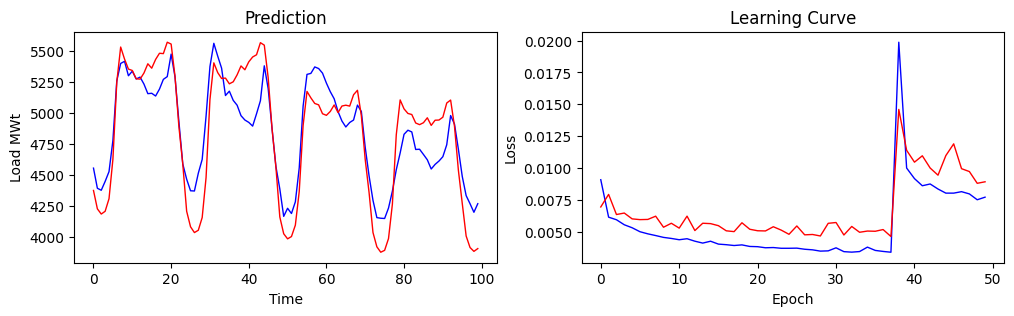



[[4375.3046875], [4227.5625], [4185.67822265625], [4207.76123046875], [4309.212890625], [4626.01416015625], [5246.4755859375], [5528.96240234375], [5431.958984375], [5351.7841796875], [5340.25732421875], [5273.78564453125], [5270.703125], [5320.06982421875], [5394.29052734375], [5358.86865234375], [5429.119140625], [5478.88232421875], [5476.06298828125], [5567.6982421875], [5552.96044921875], [5293.44921875], [4889.31201171875], [4588.271484375], [4208.03662109375], [4083.1640625], [4036.65380859375], [4055.27490234375], [4157.63037109375], [4479.16357421875], [5106.19921875], [5401.77392578125], [5323.43017578125], [5275.99609375], [5279.26611328125], [5233.14013671875], [5249.447265625], [5305.4990234375], [5376.8779296875], [5346.11669921875], [5409.70361328125], [5448.89697265625], [5466.7685546875], [5564.04443359375], [5544.12255859375], [5283.076171875], [4870.4951171875], [4559.98974609375], [4162.06201171875], [4027.187744140625], [3986.218994140625], [4004.69580078125], [40

In [ ]:
# 3. GRU-GA

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.GRU(50, return_sequences=True)(inputs)
x = layers.GRU(50, return_sequences=False)(x)
outputs = layers.Dense(24)(x)

model = Model(inputs=inputs, outputs=outputs, name="GRU")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Epoch 1/50
147/147 [==============================] - 9s 24ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/50
147/147 [==============================] - 2s 15ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/50
147/147 [==============================] - 2s 11ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 4/50
147/147 [==============================] - 2s 11ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 5/50
147/147 [==============================] - 2s 12ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/50
147/147 [==============================] - 2s 14ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7/50
147/147 [==============================] - 2s 11ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 8/50
147/147 [==============================] - 2s 14ms/step - 

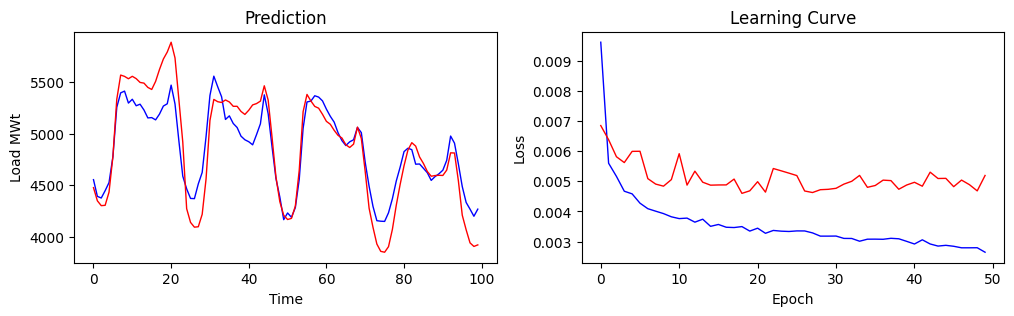



[[4477.38916015625], [4349.8857421875], [4302.86376953125], [4306.10107421875], [4433.96142578125], [4778.34619140625], [5334.79345703125], [5569.60009765625], [5556.86572265625], [5533.90380859375], [5557.67529296875], [5534.984375], [5498.0693359375], [5491.59912109375], [5449.9306640625], [5429.9599609375], [5508.10400390625], [5623.70751953125], [5725.138671875], [5792.6875], [5888.2578125], [5735.85546875], [5329.47216796875], [4919.95703125], [4273.58740234375], [4140.47021484375], [4094.106689453125], [4098.29052734375], [4218.7724609375], [4562.9208984375], [5128.708984375], [5333.46484375], [5311.3271484375], [5303.65869140625], [5328.09716796875], [5308.5439453125], [5266.5732421875], [5266.61767578125], [5216.76416015625], [5187.685546875], [5228.466796875], [5280.158203125], [5293.04296875], [5316.78662109375], [5465.56689453125], [5326.3125], [4964.58056640625], [4582.49658203125], [4341.5087890625], [4209.82568359375], [4168.37353515625], [4179.572265625], [4299.1630859

In [ ]:
# 4. CNN-LSTM

inputs = layers.Input(shape=(LOOKBACK,1))
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(24, kernel_size=7, activation='relu', padding='same')(x)
x = layers.MaxPool1D(2)(x)
x = layers.LSTM(64, return_sequences=False)(x)
outputs = layers.Dense(24,activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs, name="CNNLSTM")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=1)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
Ys_pred = model.predict(Xts)
print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:01:15
1/1 [==============================] - 1s 562ms/step

Single Day Inference Time 623.8338947296143 ms
4/4 [==============================] - 0s 7ms/step

Evaluation metric results:-

MAPE is : 4.673143103718758
R2 is : 0.8745725484018244


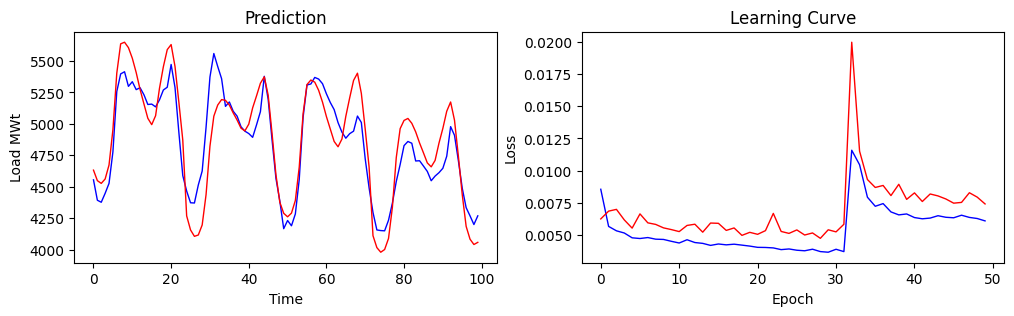



[[4632.1875], [4548.70361328125], [4526.93359375], [4561.74267578125], [4672.9853515625], [4952.39697265625], [5403.201171875], [5635.9921875], [5648.7431640625], [5605.82373046875], [5521.48388671875], [5407.59765625], [5273.35400390625], [5157.94482421875], [5044.201171875], [4993.69482421875], [5064.85888671875], [5282.279296875], [5454.02783203125], [5589.806640625], [5630.04833984375], [5455.599609375], [5169.5830078125], [4871.64990234375], [4268.90283203125], [4157.04296875], [4106.19677734375], [4116.7236328125], [4196.51220703125], [4437.9814453125], [4822.39404296875], [5060.890625], [5149.4970703125], [5192.80126953125], [5186.7578125], [5149.14404296875], [5086.302734375], [5030.1240234375], [4965.56884765625], [4944.080078125], [4997.60986328125], [5127.15087890625], [5222.564453125], [5322.845703125], [5373.61328125], [5228.09375], [4923.9794921875], [4595.76220703125], [4377.07666015625], [4289.2607421875], [4261.337890625], [4290.54345703125], [4391.16455078125], [465

In [ ]:
# 5. GRU-CNN
input_seq = layers.Input(shape=(LOOKBACK, 1))
input_img = layers.Input(shape=(7,24,1))    # (height, width, channels)

# CNN Module
conv1 = layers.Conv1D(filters=32, kernel_size=(3), activation='relu')(input_img)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv1D(filters=64, kernel_size=(3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = layers.Flatten()(pool2)

# GRU Module
gru = layers.GRU(units=64, activation='tanh', recurrent_activation='sigmoid')(input_seq)

# Concatenate the outputs of CNN and GRU modules
merged = layers.concatenate([flatten, gru])

# Fully Connected Layer
dense1 = layers.Dense(units=128, activation='relu')(merged)
outputs = layers.Dense(units=24, activation='linear', name='output_layer')(dense1)

model = Model(inputs=[input_seq, input_img], outputs=outputs, name="GRU-CNN")
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

start_time = time.time()
history = model.fit([Xs,Xs_i], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict([Xts[:1],Xts_i[:1]])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict([Xts,Xts_i])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

Training Time : 00:09:46
1/1 [==============================] - 1s 713ms/step

Single Day Inference Time 761.2674236297607 ms
4/4 [==============================] - 0s 52ms/step

Evaluation metric results:-

MAPE is : 6.5622493624687195
R2 is : 0.7526348680124739


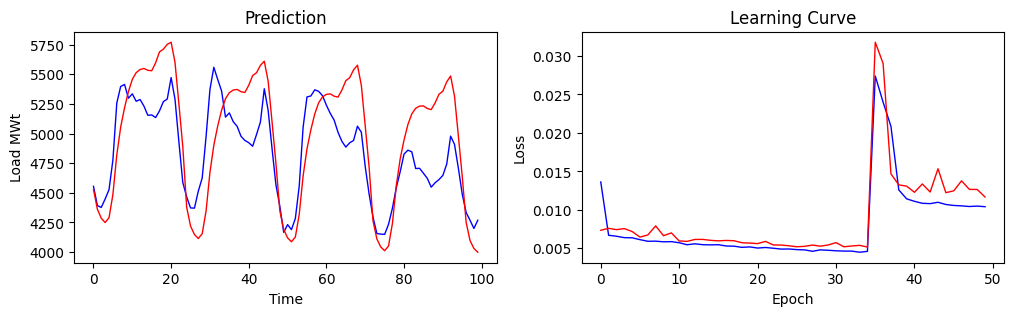



[[4529.357421875], [4362.3603515625], [4285.90185546875], [4249.89208984375], [4290.1552734375], [4486.09521484375], [4819.3974609375], [5054.10205078125], [5217.13134765625], [5353.92529296875], [5456.67138671875], [5513.97021484375], [5539.75732421875], [5549.09326171875], [5533.1875], [5529.51416015625], [5596.2255859375], [5688.58642578125], [5711.623046875], [5752.28759765625], [5770.16259765625], [5599.7734375], [5250.37548828125], [4891.48095703125], [4380.07958984375], [4220.2724609375], [4148.78173828125], [4114.95556640625], [4154.84375], [4346.84765625], [4672.63671875], [4902.06103515625], [5063.55322265625], [5197.33837890625], [5293.1787109375], [5344.93603515625], [5366.7734375], [5371.94482421875], [5353.11474609375], [5346.50830078125], [5407.3916015625], [5488.74755859375], [5513.19189453125], [5574.95703125], [5610.1513671875], [5440.5126953125], [5097.68994140625], [4747.9453125], [4349.34619140625], [4191.18408203125], [4120.79541015625], [4087.494384765625], [41

In [ ]:
# 6 PLCNET

inputs = layers.Input(shape=(LOOKBACK, 1))

# CNN Path
cnn_path = layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
cnn_path = layers.MaxPooling1D()(cnn_path)
cnn_path = layers.Conv1D(32, kernel_size=2, activation='relu')(cnn_path)
cnn_path = layers.Flatten()(cnn_path)

#LSTM Path
lstm_path = layers.LSTM(48)(inputs)

# Concatenate paths
merged_data = layers.concatenate([cnn_path, lstm_path])
merged_data = layers.Reshape((merged_data.shape[1], 1))(merged_data)

# Fully Connected Layer
fc_layer = layers.LSTM(50)(merged_data)
# fc_layer = layers.Dense(50, activation='relu')(fc_layer)
fc_layer = layers.Dropout(0.3)(fc_layer)
# Output Layer
outputs = layers.Dense(24, activation='linear')(fc_layer)

model = Model(inputs=inputs, outputs = outputs, name="PLCNet")
model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')
# model.summary()

start_time = time.time()
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

start_time = time.time()
_ = model.predict(Xts[:1])
elapsed_time = time.time() - start_time
print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Ys_pred = model.predict(Xts)
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# COMPARED WITH PREVIOUS RESULTS FROM THE LITERATURES

# 1. GEFCom2014 (An advanced deep neuroevolution model for probabilistic load forecasting)

In [ ]:
LOOKBACK=168
LOOKAHEAD=24

def reframe(data, lookback, lookahead):
    x_load, y_load = [],[]
    start = 0
    for _ in range(len(data)):
        feature_end = start + lookback
        label_end = feature_end + lookahead
        if label_end <= len(data):
            # historical load feature
            v = data[start:feature_end,0]
            # v = v.reshape(len(v),1)
            x_load.append(v)
            # load labels
            v = data[feature_end:label_end,0]
            # v = v.reshape(len(v),1)
            y_load.append(v)
        start += lookahead
    x_load = np.asarray(x_load).astype('float32')
    y_load = np.asarray(y_load).astype('float32')
    return x_load, y_load

def evaluate(ori, pre):
    ori, pre = ori.flatten(),pre.flatten()
    mape = metrics.mean_absolute_percentage_error(ori, pre)*100
    mse = metrics.mean_squared_error(ori, pre)
    rmse = math.sqrt(mse)
    r2 = metrics.r2_score(ori, pre)
    print('\nEvaluation metric results:-\n')
    print(f'MAPE is : {mape}')
    print(f'RMSE is : {rmse}')
    print(f'R2 is : {r2}')

def pplot(ori,pre,history):
    ori, pre = ori.flatten(),pre.flatten()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    axs[0].plot(ori[:100], label="Actual Load", color='blue', linewidth=1)
    axs[0].plot(pre[:100], label="Predicted Load", color='red', linewidth=1)
    axs[0].set_title("Prediction")
    axs[0].set_ylabel("Load MWt")
    axs[0].set_xlabel("Time")
    axs[1].plot(history.history['loss'], label="Training Loss", color='blue', linewidth=1)
    axs[1].plot(history.history['val_loss'], label="Validation Loss", color='red', linewidth=1)
    axs[1].set_title("Learning Curve")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    plt.show()


In [ ]:
# 1 January 2005 to 31 August 2009 is considered for training, while from 1 September 2009 to 30 September 2010 is considered for testing.(day-ahead prediction)
# 8760 to 40896 train
path = "/content/drive/MyDrive/DATASETS/GEFCom2014p.csv"
dataset = pd.read_csv(path)
dataset = dataset.drop(columns=['Date','Hour'])

train = dataset.iloc[8760:40896,:]
test = dataset.iloc[40896:,:]
train = np.array(train.values)
test = np.array(test.values)
# print(len(train), len(test))

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)


# Image Conversion GADF
transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")


X_img : (1332, 168, 168, 1), Xt_img : (388, 168, 168, 1)
Xs : (1332, 168, 1), Ys : (1332, 24)
Xts : (388, 168, 1), Yt : (388, 24)
time: 8.74 s (started: 2024-01-26 10:18:20 +00:00)


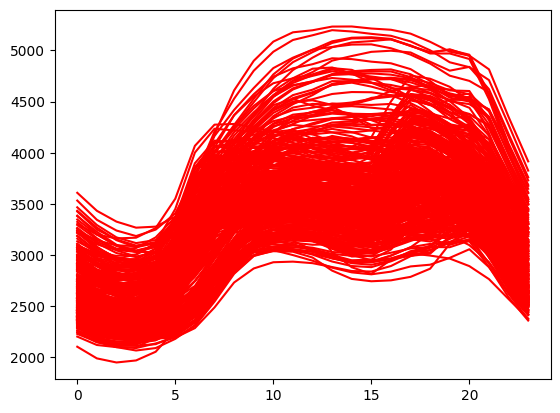

time: 1.25 s (started: 2024-01-26 10:18:34 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

Epoch 1/50
34/34 [==============================] - 6s 37ms/step - loss: 0.1649 - val_loss: 0.0201
Epoch 2/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0175 - val_loss: 0.0131
Epoch 3/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0138 - val_loss: 0.0191
Epoch 4/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0198 - val_loss: 0.0153
Epoch 5/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0144 - val_loss: 0.0115
Epoch 6/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0146 - val_loss: 0.0130
Epoch 7/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0135 - val_loss: 0.0113
Epoch 8/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 9/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0117 - val_loss: 0.0101
Epoch 10/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 11/

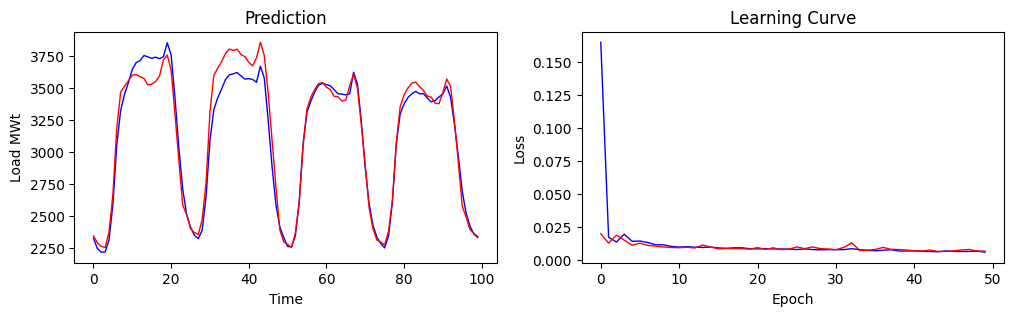



[[2346.809814453125], [2292.14208984375], [2264.782470703125], [2255.906494140625], [2375.489501953125], [2668.0283203125], [3186.666748046875], [3468.72607421875], [3512.6923828125], [3555.439453125], [3600.19091796875], [3604.789306640625], [3587.7861328125], [3574.121826171875], [3524.1572265625], [3529.798583984375], [3549.02001953125], [3592.65478515625], [3717.3388671875], [3756.421875], [3638.588134765625], [3295.71142578125], [2929.14013671875], [2584.571044921875], [2512.277099609375], [2402.48291015625], [2372.42919921875], [2356.13720703125], [2474.69384765625], [2762.49951171875], [3310.22119140625], [3596.349609375], [3654.620361328125], [3705.13427734375], [3767.725341796875], [3803.24169921875], [3791.986572265625], [3802.904052734375], [3759.599853515625], [3744.3466796875], [3699.89013671875], [3671.970947265625], [3735.913330078125], [3856.414794921875], [3751.044677734375], [3460.210693359375], [3094.8798828125], [2729.10205078125], [2392.927001953125], [2299.44604

In [ ]:
# CNNLSTM+GAF


# es = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=30,verbose=1)
rop = callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.2,min_lr=0.001)
# checkpoint_callback = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True,
#                                       mode='min',
#                                       verbose=1)
verbose, epochs, batch_size = 1, 150, 32

seq_inputs = layers.Input(shape=(LOOKBACK,1))
# img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

x1 = layers.LSTM(200, return_sequences=False)(seq_inputs)
# x2 = layers.Convolution2D(filters=20, kernel_size=7, padding='valid')(img_inputs)
# x2 = layers.GlobalAvgPool2D()(x2)
# c1 = layers.Concatenate(axis=1)([x1,x2])
outputs = layers.Dense(24, activation='linear')(x1)

model = Model(seq_inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
history = model.fit(Xs, Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=1)
Ys_pred = model.predict(Xts)


# model = Model([seq_inputs,img_inputs], outputs)
# model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# start_time = time.time()
# history = model.fit([Xs,X_img], Ys, epochs=50, validation_split=0.2,batch_size=32,verbose=0)
# print(f'Training Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

# start_time = time.time()
# Ys_pred = model.predict([Xts,Xt_img])
# print(f'\nTotal Inference Time : {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')

# start_time = time.time()
# _ = model.predict([Xts[:1],Xt_img[:1]])
# elapsed_time = time.time() - start_time
# print(f"\nSingle Day Inference Time {elapsed_time*1000} ms")

Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
evaluate(Yt.reshape(-1,1),Y_pred)
pplot(Yt.reshape(-1,1),Y_pred,history)
print("\n")
print(Y_pred.tolist())
print("\n")

# 2. MALAYSIA (On Short-Term Load Forecasting Using Machine Learning Techniques and a Novel Parallel Deep LSTM-CNN Approach)

In [ ]:
path = "/content/drive/MyDrive/DATASETS/malaysia_all_data_for_paper.csv"
dataset = pd.read_csv(path,index_col=['Datetime'],parse_dates=['Datetime'])
dataset.drop(dataset.columns[[0, 1, 2]], axis=1, inplace=True)
# n=2568 # for last 100 days
n=8760 # for 2010 as test
# n=10*7*24
train = dataset.iloc[:-n,:]
test = dataset.iloc[-n:8952,:]
train = np.array(train.values)
test = np.array(test.values)

X, Y = reframe(data=train, lookback=LOOKBACK, lookahead=LOOKAHEAD)
Xt, Yt = reframe(data=test, lookback=LOOKBACK, lookahead=LOOKAHEAD)

# Image Conversion GADF
transformer = GramianAngularField(method='difference', overlapping=False, flatten=False)
X_img = transformer.transform(X).reshape(-1,LOOKBACK,LOOKBACK,1)
Xt_img = transformer.transform(Xt).reshape(-1,LOOKBACK,LOOKBACK,1)
print(f"X_img : {X_img.shape}, Xt_img : {Xt_img.shape}")

# Feature Scaling
scaler_load = MinMaxScaler(feature_range=(-1, 1))
Xs = scaler_load.fit_transform(X.reshape(-1,1)).reshape(-1,LOOKBACK,1)
Ys = scaler_load.transform(Y.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Yts = scaler_load.transform(Yt.reshape(-1,1)).reshape(-1,LOOKAHEAD)
Xts = scaler_load.transform(Xt.reshape(-1,1)).reshape(-1,LOOKBACK,1)
print(f"Xs : {Xs.shape}, Ys : {Ys.shape}")
print(f"Xts : {Xts.shape}, Yt : {Yt.shape}")

del dataset, train, test, X, Xt, Y
gc.collect()


X_img : (358, 168, 168, 1), Xt_img : (1, 168, 168, 1)
Xs : (358, 168, 1), Ys : (358, 24)
Xts : (1, 168, 1), Yt : (1, 24)


17924

time: 4.57 s (started: 2024-01-26 08:18:33 +00:00)


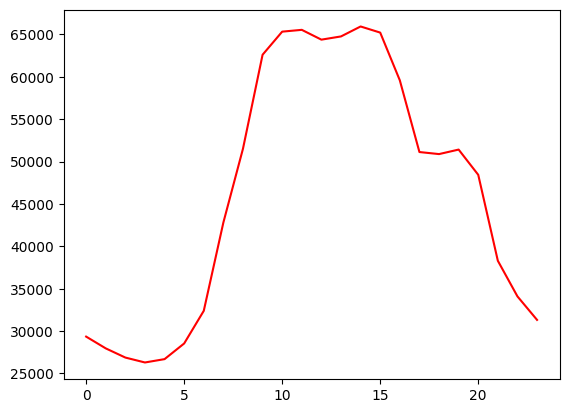

time: 259 ms (started: 2024-01-26 08:18:45 +00:00)


In [ ]:
for i in range(len(Yt)):
    plt.plot(Yt[i], color='r')
plt.show()

(None, 168, 1)  LOAD INPUTS 
(None, 50)  LOAD INPUTS->LSTM
(None, 168, 168, 1)  TEMP INPUTS 
(None, 166, 166, 10)  TEMP INPUTS->CNN
(None, 10)  TEMP INPUTS->CNN->RELU->GPOOL
(None, 60)  CONCATE
(None, 24)  CONCATE->DENSE->Output
Epoch 1/150
9/9 [==============================] - 4s 104ms/step - loss: 0.2581 - val_loss: 0.2338 - lr: 0.0010
Epoch 2/150
9/9 [==============================] - 0s 34ms/step - loss: 0.2144 - val_loss: 0.1712 - lr: 0.0010
Epoch 3/150
9/9 [==============================] - 0s 30ms/step - loss: 0.1338 - val_loss: 0.0763 - lr: 0.0010
Epoch 4/150
9/9 [==============================] - 0s 29ms/step - loss: 0.0762 - val_loss: 0.0485 - lr: 0.0010
Epoch 5/150
9/9 [==============================] - 0s 30ms/step - loss: 0.0552 - val_loss: 0.0414 - lr: 0.0010
Epoch 6/150
9/9 [==============================] - 0s 27ms/step - loss: 0.0513 - val_loss: 0.0402 - lr: 0.0010
Epoch 7/150
9/9 [==============================] - 0s 32ms/step - loss: 0.0495 - val_loss: 0.0382 - lr: 

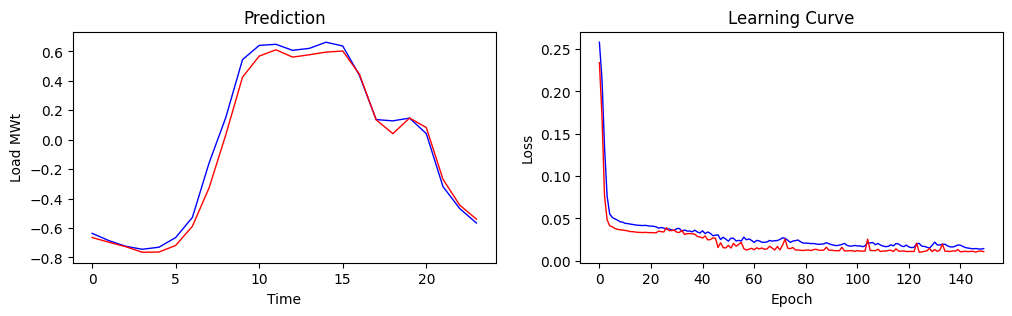



time: 41.3 s (started: 2024-01-26 08:40:10 +00:00)


In [ ]:
# CNNLSTM+GAF

# es = callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=30,verbose=1)
rop = callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.2,min_lr=0.001)
# checkpoint_callback = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True,
#                                       mode='min',
#                                       verbose=1)
verbose, epochs, batch_size = 1, 150, 32

seq_inputs = layers.Input(shape=(LOOKBACK,1))
img_inputs = layers.Input(shape=(LOOKBACK,LOOKBACK,1))

print(seq_inputs.shape," LOAD INPUTS ")
x1 = layers.LSTM(50, return_sequences=False)(seq_inputs)
print(x1.shape," LOAD INPUTS->LSTM")

print(img_inputs.shape," TEMP INPUTS ")
x2 = layers.Convolution2D(filters=10, kernel_size=3, padding='valid')(img_inputs)
print(x2.shape," TEMP INPUTS->CNN")
# x2 = layers.ReLU()(x2)
# print(x2.shape," TEMP INPUTS->CNN->RELU")
x2 = layers.GlobalAvgPool2D()(x2)
print(x2.shape," TEMP INPUTS->CNN->RELU->GPOOL")

c1 = layers.Concatenate(axis=1)([x1,x2])
print(c1.shape," CONCATE")
outputs = layers.Dense(24, activation='linear')(c1)
print(outputs.shape," CONCATE->DENSE->Output")

model = Model([seq_inputs,img_inputs], outputs)

model.compile(loss='mse', optimizer='adam')

history = model.fit([Xs,X_img], Ys, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[rop], verbose=verbose)

Ys_pred = model.predict([Xts,Xt_img])
Y_pred = scaler_load.inverse_transform(Ys_pred.reshape(-1,1))
print("R2 ", r2_score(Yt.flatten(), Y_pred.flatten()))
pplot(Yts.reshape(-1,1),Ys_pred,history)
print("\n")